This notebook contains code to extract features from the audio signals.

In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
# librosa.display.waveshow(y, sr=sr)

# ms.use('seaborn-muted')
# %matplotlib inline

In [2]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_5.pkl'.format(data_dir)
print(labels_df_path)
print(audio_vectors_path)

data/pre-processed/df_iemocap.csv
data/pre-processed/audio_vectors_5.pkl


In [3]:
labels_df = pd.read_csv(labels_df_path)

audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))
print(labels_df.head())
print(labels_df.shape)  

   start_time  end_time             wav_file emotion  val  act  dom
0      6.2901    8.2357  Ses01F_impro01_F000     neu  2.5  2.5  2.5
1     10.0100   11.3925  Ses01F_impro01_F001     neu  2.5  2.5  2.5
2     14.8872   18.0175  Ses01F_impro01_F002     neu  2.5  2.5  2.5
3     19.2900   20.7875  Ses01F_impro01_F003     xxx  2.5  3.0  3.0
4     21.3257   24.7400  Ses01F_impro01_F004     xxx  2.5  3.0  2.5
(10039, 7)


In [4]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100
print('File name:', random_file_name)
print('Audio shape:', y.shape)


File name: Ses03M_script01_1_M001
Audio shape: (117051,)


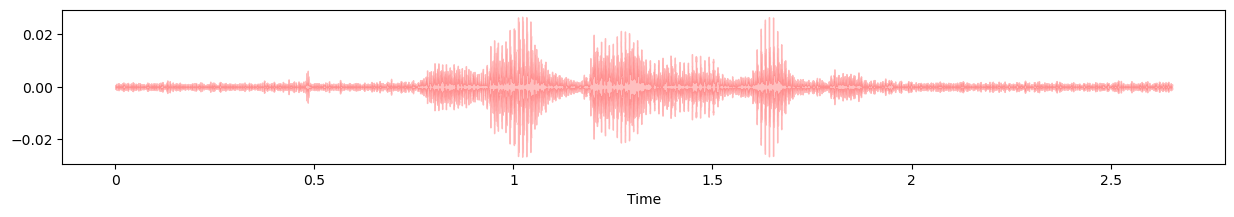

In [5]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr, alpha=0.25, color='r')

In [6]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00159
Signal std dev = 0.00282


RMSE mean = 0.00202
RMSE std dev = 0.00197


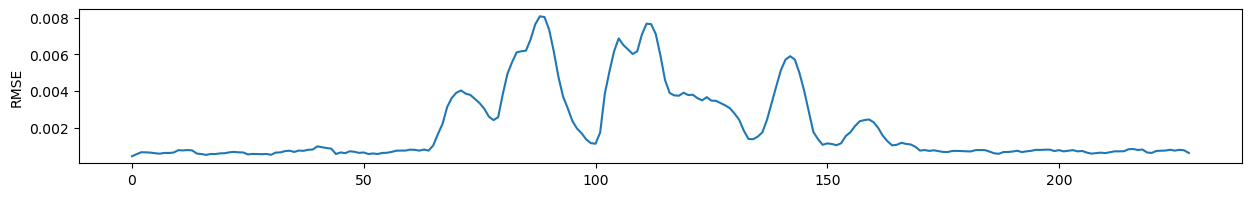

In [7]:
rmse = librosa.feature.rms(y=y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [8]:
from IPython.display import Audio
Audio(y, rate=44100)

In [9]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.4890829694323144


In [10]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-7.0742553e-06

In [11]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

0.9300368

In [12]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

0.7127925448531159

In [13]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [14]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [21]:
# Assuming labels_df is already loaded
labels_df = pd.read_csv(labels_path)
# Filter wav_files for sessions 1 to 5
# sessions = range(1,6)
sessions = range(1,2)
session_wav_files = set()


# Inisialisasi list penyimpanan fitur sementara agar lebih efisien daripada append langsung ke df 
features_list = []

# Definisikan kolom dataframe output 
columns = ['wav_file', 'label', 'sig_mean', 'sig_std',
           'rmse_mean', 'rmse_std', 'silence',
           'harmonic', 'auto_corr_max', 'auto_corr_std']

for sess in sessions:
    session_wav_files.update(labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]['wav_file'].unique())

processed_files = set()

for sess in sessions:
    with open(f'{audio_vectors_path}{sess}.pkl', 'rb') as f:
        audio_vectors = pickle.load(f)

    session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]

    for _, row in tqdm(session_labels_df.iterrows(), total=len(session_labels_df)):
        wav_file_name = row['wav_file']

        # Skip if already processed (in case of duplicates)
        if wav_file_name in processed_files:
            continue

        try:
            wav_file_name = row['wav_file']
            # print('Processing file:', wav_file_name)
            label = emotion_dict[row['emotion']]
            
            feature_list = [wav_file_name, label]  # wav_file, label
            sig_mean = np.mean(abs(y))
            feature_list.append(sig_mean)  # sig_mean
            feature_list.append(np.std(y))  # sig_std
            

            rmse = librosa.feature.rms(y=y + 0.0001)[0]
            feature_list.append(np.mean(rmse))  # rmse_mean
            feature_list.append(np.std(rmse))  # rmse_std
            
            silence = 0
            for e in rmse:
                if e <= 0.4 * np.mean(rmse):
                    silence += 1
            silence /= float(len(rmse))
            feature_list.append(silence)  # silence
        
            y_harmonic = librosa.effects.hpss(y)[0]
            feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)
        

            # based on the pitch detection algorithm mentioned here:
            # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
            cl = 0.45 * sig_mean
            center_clipped = []
            for s in y:
                if s >= cl:
                    center_clipped.append(s - cl)
                elif s <= -cl:
                    center_clipped.append(s + cl)
                elif np.abs(s) < cl:
                    center_clipped.append(0)
            auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
            feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
            feature_list.append(np.std(auto_corrs))  # auto_corr_std
        

            features_list.append(feature_list)
            df_features=pd.DataFrame(features_list, columns=columns)

            # df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            
        except Exception as e:
            print('Processing file:', wav_file_name)
            print('Some exception occurred: {}'.format(e))

    else:  
        # Continue outer loop only if inner loop did NOT break
        continue  
    # Inner loop broke -> exit outer loop too
    break 
df_features.to_csv('data/pre-processed/audio_features.csv', index=False)

 42%|████▏     | 770/1819 [11:22<15:03,  1.16it/s]

Processing file: Ses01F_script03_1_M030
Some exception occurred: 'dis'


100%|██████████| 1819/1819 [27:21<00:00,  1.11it/s]


In [146]:
labels_df = pd.read_csv(labels_path)

# Inisialisasi list penyimpanan fitur sementara agar lebih efisien daripada append langsung ke df 
features_list = []

# Definisikan kolom dataframe output 
columns = ['wav_file', 'label', 'sig_mean', 'sig_std',
           'rmse_mean', 'rmse_std', 'silence',
           'harmonic', 'auto_corr_max', 'auto_corr_std']

for sess in (range(1, 6)):
# for sess in [1]:
        # Load dictionary vektor audio per session 
        with open(f'{audio_vectors_path}{sess}.pkl','rb') as f:
            audio_vectors = pickle.load(f)

        # Filter rows sesuai session saat ini 
        session_labels_df = labels_df[labels_df['wav_file'].str.contains(f'Ses0{sess}')]
        for _, row in tqdm(session_labels_df.iterrows(), total=len(session_labels_df), desc=f'Processing Session {sess}'):

            try:
                wav_file_name = row['wav_file']
                print('Processing file:', wav_file_name)
                label = emotion_dict[row['emotion']]
               
                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std
             

                rmse = librosa.feature.rms(y=y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std
               
                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence
          
                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)
         

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std
            

                features_list.append(feature_list)
                df_features=pd.DataFrame(features_list, columns=columns)

                # df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
                
            except Exception as e:
                print('Some exception occurred: {}'.format(e))

df_features.to_csv('data/pre-processed/audio_features.csv', index=False)

Processing Session 1:   0%|          | 0/1819 [00:00<?, ?it/s]

Processing file: Ses01F_impro01_F000


Processing Session 1:   0%|          | 1/1819 [00:01<41:06,  1.36s/it]

Processing file: Ses01F_impro01_F001


Processing Session 1:   0%|          | 2/1819 [00:02<41:31,  1.37s/it]

Processing file: Ses01F_impro01_F002


Processing Session 1:   0%|          | 3/1819 [00:04<41:47,  1.38s/it]

Processing file: Ses01F_impro01_F003


Processing Session 1:   0%|          | 4/1819 [00:05<41:11,  1.36s/it]

Processing file: Ses01F_impro01_F004


Processing Session 1:   0%|          | 5/1819 [00:06<41:48,  1.38s/it]

Processing file: Ses01F_impro01_F005


Processing Session 1:   0%|          | 6/1819 [00:08<41:18,  1.37s/it]

Processing file: Ses01F_impro01_F006


Processing Session 1:   0%|          | 7/1819 [00:09<40:43,  1.35s/it]

Processing file: Ses01F_impro01_F007


Processing Session 1:   0%|          | 8/1819 [00:10<40:51,  1.35s/it]

Processing file: Ses01F_impro01_F008


Processing Session 1:   0%|          | 9/1819 [00:12<40:46,  1.35s/it]

Processing file: Ses01F_impro01_F009


Processing Session 1:   1%|          | 10/1819 [00:13<40:46,  1.35s/it]

Processing file: Ses01F_impro01_F010


Processing Session 1:   1%|          | 11/1819 [00:14<40:42,  1.35s/it]

Processing file: Ses01F_impro01_F011


Processing Session 1:   1%|          | 12/1819 [00:16<41:05,  1.36s/it]

Processing file: Ses01F_impro01_F012


Processing Session 1:   1%|          | 13/1819 [00:17<40:56,  1.36s/it]

Processing file: Ses01F_impro01_F013


Processing Session 1:   1%|          | 14/1819 [00:19<41:00,  1.36s/it]

Processing file: Ses01F_impro01_F014


Processing Session 1:   1%|          | 15/1819 [00:20<40:50,  1.36s/it]

Processing file: Ses01F_impro01_F015


Processing Session 1:   1%|          | 16/1819 [00:21<41:33,  1.38s/it]

Processing file: Ses01F_impro01_M000


Processing Session 1:   1%|          | 17/1819 [00:23<41:50,  1.39s/it]

Processing file: Ses01F_impro01_M001


Processing Session 1:   1%|          | 18/1819 [00:24<41:37,  1.39s/it]

Processing file: Ses01F_impro01_M002


Processing Session 1:   1%|          | 19/1819 [00:26<42:03,  1.40s/it]

Processing file: Ses01F_impro01_M003


Processing Session 1:   1%|          | 20/1819 [00:27<41:47,  1.39s/it]

Processing file: Ses01F_impro01_M004


Processing Session 1:   1%|          | 21/1819 [00:28<41:54,  1.40s/it]

Processing file: Ses01F_impro01_M005


Processing Session 1:   1%|          | 22/1819 [00:30<41:39,  1.39s/it]

Processing file: Ses01F_impro01_M006


Processing Session 1:   1%|▏         | 23/1819 [00:31<41:14,  1.38s/it]

Processing file: Ses01F_impro01_M007


Processing Session 1:   1%|▏         | 24/1819 [00:32<41:01,  1.37s/it]

Processing file: Ses01F_impro01_M008


Processing Session 1:   1%|▏         | 25/1819 [00:34<41:06,  1.37s/it]

Processing file: Ses01F_impro01_M009


Processing Session 1:   1%|▏         | 26/1819 [00:35<41:23,  1.39s/it]

Processing file: Ses01F_impro01_M010


Processing Session 1:   1%|▏         | 27/1819 [00:37<41:22,  1.39s/it]

Processing file: Ses01F_impro01_M011


Processing Session 1:   2%|▏         | 28/1819 [00:38<41:03,  1.38s/it]

Processing file: Ses01F_impro01_M012


Processing Session 1:   2%|▏         | 29/1819 [00:39<41:15,  1.38s/it]

Processing file: Ses01F_impro01_M013


Processing Session 1:   2%|▏         | 30/1819 [00:41<41:03,  1.38s/it]

Processing file: Ses01F_impro02_F000


Processing Session 1:   2%|▏         | 31/1819 [00:42<40:50,  1.37s/it]

Processing file: Ses01F_impro02_F001


Processing Session 1:   2%|▏         | 32/1819 [00:43<40:47,  1.37s/it]

Processing file: Ses01F_impro02_F002


Processing Session 1:   2%|▏         | 33/1819 [00:45<40:42,  1.37s/it]

Processing file: Ses01F_impro02_F003


Processing Session 1:   2%|▏         | 34/1819 [00:46<40:39,  1.37s/it]

Processing file: Ses01F_impro02_F004


Processing Session 1:   2%|▏         | 35/1819 [00:48<40:39,  1.37s/it]

Processing file: Ses01F_impro02_F005


Processing Session 1:   2%|▏         | 36/1819 [00:49<40:46,  1.37s/it]

Processing file: Ses01F_impro02_F006


Processing Session 1:   2%|▏         | 37/1819 [00:50<40:44,  1.37s/it]

Processing file: Ses01F_impro02_F007


Processing Session 1:   2%|▏         | 38/1819 [00:52<40:22,  1.36s/it]

Processing file: Ses01F_impro02_F008


Processing Session 1:   2%|▏         | 39/1819 [00:53<40:10,  1.35s/it]

Processing file: Ses01F_impro02_F009


Processing Session 1:   2%|▏         | 40/1819 [00:54<40:07,  1.35s/it]

Processing file: Ses01F_impro02_F010


Processing Session 1:   2%|▏         | 41/1819 [00:56<39:57,  1.35s/it]

Processing file: Ses01F_impro02_F011


Processing Session 1:   2%|▏         | 42/1819 [00:57<40:03,  1.35s/it]

Processing file: Ses01F_impro02_F012


Processing Session 1:   2%|▏         | 43/1819 [00:58<40:46,  1.38s/it]

Processing file: Ses01F_impro02_F013


Processing Session 1:   2%|▏         | 44/1819 [01:00<42:40,  1.44s/it]

Processing file: Ses01F_impro02_F014


Processing Session 1:   2%|▏         | 45/1819 [01:01<42:01,  1.42s/it]

Processing file: Ses01F_impro02_F015


Processing Session 1:   3%|▎         | 46/1819 [01:03<41:28,  1.40s/it]

Processing file: Ses01F_impro02_F016


Processing Session 1:   3%|▎         | 47/1819 [01:04<40:45,  1.38s/it]

Processing file: Ses01F_impro02_F017


Processing Session 1:   3%|▎         | 48/1819 [01:05<40:23,  1.37s/it]

Processing file: Ses01F_impro02_F018


Processing Session 1:   3%|▎         | 49/1819 [01:07<39:55,  1.35s/it]

Processing file: Ses01F_impro02_F019


Processing Session 1:   3%|▎         | 50/1819 [01:08<39:57,  1.36s/it]

Processing file: Ses01F_impro02_F020


Processing Session 1:   3%|▎         | 51/1819 [01:09<39:38,  1.35s/it]

Processing file: Ses01F_impro02_M000


Processing Session 1:   3%|▎         | 52/1819 [01:11<39:44,  1.35s/it]

Processing file: Ses01F_impro02_M001


Processing Session 1:   3%|▎         | 53/1819 [01:12<39:30,  1.34s/it]

Processing file: Ses01F_impro02_M002


Processing Session 1:   3%|▎         | 54/1819 [01:13<39:22,  1.34s/it]

Processing file: Ses01F_impro02_M003


Processing Session 1:   3%|▎         | 55/1819 [01:15<39:16,  1.34s/it]

Processing file: Ses01F_impro02_M004


Processing Session 1:   3%|▎         | 56/1819 [01:16<39:57,  1.36s/it]

Processing file: Ses01F_impro02_M005


Processing Session 1:   3%|▎         | 57/1819 [01:18<39:30,  1.35s/it]

Processing file: Ses01F_impro02_M006


Processing Session 1:   3%|▎         | 58/1819 [01:19<39:23,  1.34s/it]

Processing file: Ses01F_impro02_M007


Processing Session 1:   3%|▎         | 59/1819 [01:20<39:45,  1.36s/it]

Processing file: Ses01F_impro02_M008


Processing Session 1:   3%|▎         | 60/1819 [01:22<39:44,  1.36s/it]

Processing file: Ses01F_impro02_M009


Processing Session 1:   3%|▎         | 61/1819 [01:23<39:59,  1.36s/it]

Processing file: Ses01F_impro02_M010


Processing Session 1:   3%|▎         | 62/1819 [01:24<40:18,  1.38s/it]

Processing file: Ses01F_impro02_M011


Processing Session 1:   3%|▎         | 63/1819 [01:26<40:01,  1.37s/it]

Processing file: Ses01F_impro02_M012


Processing Session 1:   4%|▎         | 64/1819 [01:27<39:44,  1.36s/it]

Processing file: Ses01F_impro02_M013


Processing Session 1:   4%|▎         | 65/1819 [01:28<39:50,  1.36s/it]

Processing file: Ses01F_impro02_M014


Processing Session 1:   4%|▎         | 66/1819 [01:30<39:27,  1.35s/it]

Processing file: Ses01F_impro02_M015


Processing Session 1:   4%|▎         | 67/1819 [01:31<39:40,  1.36s/it]

Processing file: Ses01F_impro02_M016


Processing Session 1:   4%|▎         | 68/1819 [01:32<39:14,  1.34s/it]

Processing file: Ses01F_impro03_F000


Processing Session 1:   4%|▍         | 69/1819 [01:34<39:24,  1.35s/it]

Processing file: Ses01F_impro03_F001


Processing Session 1:   4%|▍         | 70/1819 [01:35<39:20,  1.35s/it]

Processing file: Ses01F_impro03_F002


Processing Session 1:   4%|▍         | 71/1819 [01:37<39:34,  1.36s/it]

Processing file: Ses01F_impro03_F003


Processing Session 1:   4%|▍         | 72/1819 [01:38<39:32,  1.36s/it]

Processing file: Ses01F_impro03_F004


Processing Session 1:   4%|▍         | 73/1819 [01:39<39:15,  1.35s/it]

Processing file: Ses01F_impro03_F005


Processing Session 1:   4%|▍         | 74/1819 [01:41<39:38,  1.36s/it]

Processing file: Ses01F_impro03_F006


Processing Session 1:   4%|▍         | 75/1819 [01:42<39:44,  1.37s/it]

Processing file: Ses01F_impro03_F007


Processing Session 1:   4%|▍         | 76/1819 [01:43<39:23,  1.36s/it]

Processing file: Ses01F_impro03_F008


Processing Session 1:   4%|▍         | 77/1819 [01:45<39:22,  1.36s/it]

Processing file: Ses01F_impro03_F009


Processing Session 1:   4%|▍         | 78/1819 [01:46<39:11,  1.35s/it]

Processing file: Ses01F_impro03_F010


Processing Session 1:   4%|▍         | 79/1819 [01:47<39:04,  1.35s/it]

Processing file: Ses01F_impro03_F011


Processing Session 1:   4%|▍         | 80/1819 [01:49<38:55,  1.34s/it]

Processing file: Ses01F_impro03_F012


Processing Session 1:   4%|▍         | 81/1819 [01:50<38:57,  1.34s/it]

Processing file: Ses01F_impro03_F013


Processing Session 1:   5%|▍         | 82/1819 [01:51<38:50,  1.34s/it]

Processing file: Ses01F_impro03_F014


Processing Session 1:   5%|▍         | 83/1819 [01:53<38:48,  1.34s/it]

Processing file: Ses01F_impro03_F015


Processing Session 1:   5%|▍         | 84/1819 [01:54<38:53,  1.34s/it]

Processing file: Ses01F_impro03_F016


Processing Session 1:   5%|▍         | 85/1819 [01:55<39:10,  1.36s/it]

Processing file: Ses01F_impro03_F017


Processing Session 1:   5%|▍         | 86/1819 [01:57<39:12,  1.36s/it]

Processing file: Ses01F_impro03_F018


Processing Session 1:   5%|▍         | 87/1819 [01:58<38:47,  1.34s/it]

Processing file: Ses01F_impro03_F019


Processing Session 1:   5%|▍         | 88/1819 [01:59<38:47,  1.34s/it]

Processing file: Ses01F_impro03_F020


Processing Session 1:   5%|▍         | 89/1819 [02:01<38:52,  1.35s/it]

Processing file: Ses01F_impro03_F021


Processing Session 1:   5%|▍         | 90/1819 [02:02<39:03,  1.36s/it]

Processing file: Ses01F_impro03_F022


Processing Session 1:   5%|▌         | 91/1819 [02:04<38:55,  1.35s/it]

Processing file: Ses01F_impro03_F023


Processing Session 1:   5%|▌         | 92/1819 [02:05<39:03,  1.36s/it]

Processing file: Ses01F_impro03_F024


Processing Session 1:   5%|▌         | 93/1819 [02:06<38:41,  1.35s/it]

Processing file: Ses01F_impro03_F025


Processing Session 1:   5%|▌         | 94/1819 [02:08<39:22,  1.37s/it]

Processing file: Ses01F_impro03_F026


Processing Session 1:   5%|▌         | 95/1819 [02:09<39:06,  1.36s/it]

Processing file: Ses01F_impro03_M000


Processing Session 1:   5%|▌         | 96/1819 [02:10<38:47,  1.35s/it]

Processing file: Ses01F_impro03_M001


Processing Session 1:   5%|▌         | 97/1819 [02:12<39:07,  1.36s/it]

Processing file: Ses01F_impro03_M002


Processing Session 1:   5%|▌         | 98/1819 [02:13<39:22,  1.37s/it]

Processing file: Ses01F_impro03_M003


Processing Session 1:   5%|▌         | 99/1819 [02:14<38:52,  1.36s/it]

Processing file: Ses01F_impro03_M004


Processing Session 1:   5%|▌         | 100/1819 [02:16<39:01,  1.36s/it]

Processing file: Ses01F_impro03_M005


Processing Session 1:   6%|▌         | 101/1819 [02:17<38:56,  1.36s/it]

Processing file: Ses01F_impro03_M006


Processing Session 1:   6%|▌         | 102/1819 [02:19<38:52,  1.36s/it]

Processing file: Ses01F_impro03_M007


Processing Session 1:   6%|▌         | 103/1819 [02:20<38:35,  1.35s/it]

Processing file: Ses01F_impro03_M008


Processing Session 1:   6%|▌         | 104/1819 [02:21<38:15,  1.34s/it]

Processing file: Ses01F_impro03_M009


Processing Session 1:   6%|▌         | 105/1819 [02:22<38:09,  1.34s/it]

Processing file: Ses01F_impro03_M010


Processing Session 1:   6%|▌         | 106/1819 [02:24<38:17,  1.34s/it]

Processing file: Ses01F_impro03_M011


Processing Session 1:   6%|▌         | 107/1819 [02:25<38:50,  1.36s/it]

Processing file: Ses01F_impro03_M012


Processing Session 1:   6%|▌         | 108/1819 [02:27<39:24,  1.38s/it]

Processing file: Ses01F_impro03_M013


Processing Session 1:   6%|▌         | 109/1819 [02:28<39:19,  1.38s/it]

Processing file: Ses01F_impro03_M014


Processing Session 1:   6%|▌         | 110/1819 [02:29<38:59,  1.37s/it]

Processing file: Ses01F_impro03_M015


Processing Session 1:   6%|▌         | 111/1819 [02:31<38:58,  1.37s/it]

Processing file: Ses01F_impro03_M016


Processing Session 1:   6%|▌         | 112/1819 [02:32<39:07,  1.38s/it]

Processing file: Ses01F_impro03_M017


Processing Session 1:   6%|▌         | 113/1819 [02:34<40:10,  1.41s/it]

Processing file: Ses01F_impro03_M018


Processing Session 1:   6%|▋         | 114/1819 [02:35<39:58,  1.41s/it]

Processing file: Ses01F_impro03_M019


Processing Session 1:   6%|▋         | 115/1819 [02:36<39:40,  1.40s/it]

Processing file: Ses01F_impro03_M020


Processing Session 1:   6%|▋         | 116/1819 [02:38<39:08,  1.38s/it]

Processing file: Ses01F_impro03_M021


Processing Session 1:   6%|▋         | 117/1819 [02:39<38:50,  1.37s/it]

Processing file: Ses01F_impro03_M022


Processing Session 1:   6%|▋         | 118/1819 [02:41<39:05,  1.38s/it]

Processing file: Ses01F_impro03_M023


Processing Session 1:   7%|▋         | 119/1819 [02:42<39:01,  1.38s/it]

Processing file: Ses01F_impro03_M024


Processing Session 1:   7%|▋         | 120/1819 [02:43<39:07,  1.38s/it]

Processing file: Ses01F_impro04_F000


Processing Session 1:   7%|▋         | 121/1819 [02:45<39:00,  1.38s/it]

Processing file: Ses01F_impro04_F001


Processing Session 1:   7%|▋         | 122/1819 [02:46<39:14,  1.39s/it]

Processing file: Ses01F_impro04_F002


Processing Session 1:   7%|▋         | 123/1819 [02:47<39:05,  1.38s/it]

Processing file: Ses01F_impro04_F003


Processing Session 1:   7%|▋         | 124/1819 [02:49<39:00,  1.38s/it]

Processing file: Ses01F_impro04_F004


Processing Session 1:   7%|▋         | 125/1819 [02:50<38:45,  1.37s/it]

Processing file: Ses01F_impro04_F005


Processing Session 1:   7%|▋         | 126/1819 [02:52<38:41,  1.37s/it]

Processing file: Ses01F_impro04_F006


Processing Session 1:   7%|▋         | 127/1819 [02:53<38:41,  1.37s/it]

Processing file: Ses01F_impro04_F007


Processing Session 1:   7%|▋         | 128/1819 [02:54<38:19,  1.36s/it]

Processing file: Ses01F_impro04_F008


Processing Session 1:   7%|▋         | 129/1819 [02:56<38:39,  1.37s/it]

Processing file: Ses01F_impro04_F009


Processing Session 1:   7%|▋         | 130/1819 [02:57<38:06,  1.35s/it]

Processing file: Ses01F_impro04_F010


Processing Session 1:   7%|▋         | 131/1819 [02:58<38:12,  1.36s/it]

Processing file: Ses01F_impro04_F011


Processing Session 1:   7%|▋         | 132/1819 [03:00<38:15,  1.36s/it]

Processing file: Ses01F_impro04_F012


Processing Session 1:   7%|▋         | 133/1819 [03:01<38:21,  1.36s/it]

Processing file: Ses01F_impro04_F013


Processing Session 1:   7%|▋         | 134/1819 [03:02<38:06,  1.36s/it]

Processing file: Ses01F_impro04_F014


Processing Session 1:   7%|▋         | 135/1819 [03:04<38:26,  1.37s/it]

Processing file: Ses01F_impro04_F015


Processing Session 1:   7%|▋         | 136/1819 [03:05<38:20,  1.37s/it]

Processing file: Ses01F_impro04_F016


Processing Session 1:   8%|▊         | 137/1819 [03:07<38:06,  1.36s/it]

Processing file: Ses01F_impro04_F017


Processing Session 1:   8%|▊         | 138/1819 [03:08<38:12,  1.36s/it]

Processing file: Ses01F_impro04_F018


Processing Session 1:   8%|▊         | 139/1819 [03:09<37:57,  1.36s/it]

Processing file: Ses01F_impro04_F019


Processing Session 1:   8%|▊         | 140/1819 [03:11<38:03,  1.36s/it]

Processing file: Ses01F_impro04_F020


Processing Session 1:   8%|▊         | 141/1819 [03:12<37:55,  1.36s/it]

Processing file: Ses01F_impro04_F021


Processing Session 1:   8%|▊         | 142/1819 [03:13<37:54,  1.36s/it]

Processing file: Ses01F_impro04_F022


Processing Session 1:   8%|▊         | 143/1819 [03:15<37:43,  1.35s/it]

Processing file: Ses01F_impro04_F023


Processing Session 1:   8%|▊         | 144/1819 [03:16<38:06,  1.37s/it]

Processing file: Ses01F_impro04_F024


Processing Session 1:   8%|▊         | 145/1819 [03:17<37:58,  1.36s/it]

Processing file: Ses01F_impro04_F025


Processing Session 1:   8%|▊         | 146/1819 [03:19<38:13,  1.37s/it]

Processing file: Ses01F_impro04_F026


Processing Session 1:   8%|▊         | 147/1819 [03:20<38:57,  1.40s/it]

Processing file: Ses01F_impro04_F027


Processing Session 1:   8%|▊         | 148/1819 [03:22<38:18,  1.38s/it]

Processing file: Ses01F_impro04_F028


Processing Session 1:   8%|▊         | 149/1819 [03:23<37:58,  1.36s/it]

Processing file: Ses01F_impro04_F029


Processing Session 1:   8%|▊         | 150/1819 [03:24<37:56,  1.36s/it]

Processing file: Ses01F_impro04_F030


Processing Session 1:   8%|▊         | 151/1819 [03:26<38:03,  1.37s/it]

Processing file: Ses01F_impro04_F031


Processing Session 1:   8%|▊         | 152/1819 [03:27<37:51,  1.36s/it]

Processing file: Ses01F_impro04_F032


Processing Session 1:   8%|▊         | 153/1819 [03:28<37:53,  1.36s/it]

Processing file: Ses01F_impro04_F033


Processing Session 1:   8%|▊         | 154/1819 [03:30<37:37,  1.36s/it]

Processing file: Ses01F_impro04_M000


Processing Session 1:   9%|▊         | 155/1819 [03:31<37:25,  1.35s/it]

Processing file: Ses01F_impro04_M001


Processing Session 1:   9%|▊         | 156/1819 [03:32<37:36,  1.36s/it]

Processing file: Ses01F_impro04_M002


Processing Session 1:   9%|▊         | 157/1819 [03:34<37:16,  1.35s/it]

Processing file: Ses01F_impro04_M003


Processing Session 1:   9%|▊         | 158/1819 [03:35<37:27,  1.35s/it]

Processing file: Ses01F_impro04_M004


Processing Session 1:   9%|▊         | 159/1819 [03:36<37:08,  1.34s/it]

Processing file: Ses01F_impro04_M005


Processing Session 1:   9%|▉         | 160/1819 [03:38<37:04,  1.34s/it]

Processing file: Ses01F_impro04_M006


Processing Session 1:   9%|▉         | 161/1819 [03:39<37:14,  1.35s/it]

Processing file: Ses01F_impro04_M007


Processing Session 1:   9%|▉         | 162/1819 [03:40<36:53,  1.34s/it]

Processing file: Ses01F_impro04_M008


Processing Session 1:   9%|▉         | 163/1819 [03:42<37:13,  1.35s/it]

Processing file: Ses01F_impro04_M009


Processing Session 1:   9%|▉         | 164/1819 [03:43<37:15,  1.35s/it]

Processing file: Ses01F_impro04_M010


Processing Session 1:   9%|▉         | 165/1819 [03:44<36:55,  1.34s/it]

Processing file: Ses01F_impro04_M011


Processing Session 1:   9%|▉         | 166/1819 [03:46<36:47,  1.34s/it]

Processing file: Ses01F_impro04_M012


Processing Session 1:   9%|▉         | 167/1819 [03:47<36:56,  1.34s/it]

Processing file: Ses01F_impro04_M013


Processing Session 1:   9%|▉         | 168/1819 [03:48<36:48,  1.34s/it]

Processing file: Ses01F_impro04_M014


Processing Session 1:   9%|▉         | 169/1819 [03:50<36:49,  1.34s/it]

Processing file: Ses01F_impro04_M015


Processing Session 1:   9%|▉         | 170/1819 [03:51<36:43,  1.34s/it]

Processing file: Ses01F_impro04_M016


Processing Session 1:   9%|▉         | 171/1819 [03:52<36:37,  1.33s/it]

Processing file: Ses01F_impro04_M017


Processing Session 1:   9%|▉         | 172/1819 [03:54<36:32,  1.33s/it]

Processing file: Ses01F_impro04_M018


Processing Session 1:  10%|▉         | 173/1819 [03:55<36:33,  1.33s/it]

Processing file: Ses01F_impro04_M019


Processing Session 1:  10%|▉         | 174/1819 [03:56<36:41,  1.34s/it]

Processing file: Ses01F_impro04_M020


Processing Session 1:  10%|▉         | 175/1819 [03:58<36:31,  1.33s/it]

Processing file: Ses01F_impro04_M021


Processing Session 1:  10%|▉         | 176/1819 [03:59<36:36,  1.34s/it]

Processing file: Ses01F_impro04_M022


Processing Session 1:  10%|▉         | 177/1819 [04:00<36:36,  1.34s/it]

Processing file: Ses01F_impro04_M023


Processing Session 1:  10%|▉         | 178/1819 [04:02<36:38,  1.34s/it]

Processing file: Ses01F_impro04_M024


Processing Session 1:  10%|▉         | 179/1819 [04:03<36:30,  1.34s/it]

Processing file: Ses01F_impro04_M025


Processing Session 1:  10%|▉         | 180/1819 [04:04<36:23,  1.33s/it]

Processing file: Ses01F_impro04_M026


Processing Session 1:  10%|▉         | 181/1819 [04:06<36:24,  1.33s/it]

Processing file: Ses01F_impro04_M027


Processing Session 1:  10%|█         | 182/1819 [04:07<36:38,  1.34s/it]

Processing file: Ses01F_impro04_M028


Processing Session 1:  10%|█         | 183/1819 [04:09<36:52,  1.35s/it]

Processing file: Ses01F_impro04_M029


Processing Session 1:  10%|█         | 184/1819 [04:10<37:26,  1.37s/it]

Processing file: Ses01F_impro04_M030


Processing Session 1:  10%|█         | 185/1819 [04:11<37:30,  1.38s/it]

Processing file: Ses01F_impro04_M031


Processing Session 1:  10%|█         | 186/1819 [04:13<37:16,  1.37s/it]

Processing file: Ses01F_impro04_M032


Processing Session 1:  10%|█         | 187/1819 [04:14<36:50,  1.35s/it]

Processing file: Ses01F_impro04_M033


Processing Session 1:  10%|█         | 188/1819 [04:15<36:49,  1.35s/it]

Processing file: Ses01F_impro04_M034


Processing Session 1:  10%|█         | 189/1819 [04:17<36:35,  1.35s/it]

Processing file: Ses01F_impro04_M035


Processing Session 1:  10%|█         | 190/1819 [04:18<36:29,  1.34s/it]

Processing file: Ses01F_impro04_M036


Processing Session 1:  11%|█         | 191/1819 [04:19<36:33,  1.35s/it]

Processing file: Ses01F_impro05_F000


Processing Session 1:  11%|█         | 192/1819 [04:21<36:23,  1.34s/it]

Processing file: Ses01F_impro05_F001


Processing Session 1:  11%|█         | 193/1819 [04:22<36:09,  1.33s/it]

Processing file: Ses01F_impro05_F002


Processing Session 1:  11%|█         | 194/1819 [04:23<36:10,  1.34s/it]

Processing file: Ses01F_impro05_F003


Processing Session 1:  11%|█         | 195/1819 [04:25<36:29,  1.35s/it]

Processing file: Ses01F_impro05_F004


Processing Session 1:  11%|█         | 196/1819 [04:26<36:22,  1.34s/it]

Processing file: Ses01F_impro05_F005


Processing Session 1:  11%|█         | 197/1819 [04:28<36:47,  1.36s/it]

Processing file: Ses01F_impro05_F006


Processing Session 1:  11%|█         | 198/1819 [04:29<36:30,  1.35s/it]

Processing file: Ses01F_impro05_F007


Processing Session 1:  11%|█         | 199/1819 [04:30<36:28,  1.35s/it]

Processing file: Ses01F_impro05_F008


Processing Session 1:  11%|█         | 200/1819 [04:32<36:21,  1.35s/it]

Processing file: Ses01F_impro05_F009


Processing Session 1:  11%|█         | 201/1819 [04:33<36:16,  1.35s/it]

Processing file: Ses01F_impro05_F010


Processing Session 1:  11%|█         | 202/1819 [04:34<36:32,  1.36s/it]

Processing file: Ses01F_impro05_F011


Processing Session 1:  11%|█         | 203/1819 [04:36<36:44,  1.36s/it]

Processing file: Ses01F_impro05_F012


Processing Session 1:  11%|█         | 204/1819 [04:37<36:28,  1.36s/it]

Processing file: Ses01F_impro05_F013


Processing Session 1:  11%|█▏        | 205/1819 [04:38<36:27,  1.36s/it]

Processing file: Ses01F_impro05_F014


Processing Session 1:  11%|█▏        | 206/1819 [04:40<36:24,  1.35s/it]

Processing file: Ses01F_impro05_F015


Processing Session 1:  11%|█▏        | 207/1819 [04:41<36:11,  1.35s/it]

Processing file: Ses01F_impro05_F016


Processing Session 1:  11%|█▏        | 208/1819 [04:42<36:18,  1.35s/it]

Processing file: Ses01F_impro05_F017


Processing Session 1:  11%|█▏        | 209/1819 [04:44<36:25,  1.36s/it]

Processing file: Ses01F_impro05_F018


Processing Session 1:  12%|█▏        | 210/1819 [04:45<36:20,  1.36s/it]

Processing file: Ses01F_impro05_F019


Processing Session 1:  12%|█▏        | 211/1819 [04:47<37:00,  1.38s/it]

Processing file: Ses01F_impro05_F020


Processing Session 1:  12%|█▏        | 212/1819 [04:48<38:04,  1.42s/it]

Processing file: Ses01F_impro05_F021


Processing Session 1:  12%|█▏        | 213/1819 [04:49<37:43,  1.41s/it]

Processing file: Ses01F_impro05_F022


Processing Session 1:  12%|█▏        | 214/1819 [04:51<37:09,  1.39s/it]

Processing file: Ses01F_impro05_F023


Processing Session 1:  12%|█▏        | 215/1819 [04:52<36:47,  1.38s/it]

Processing file: Ses01F_impro05_F024


Processing Session 1:  12%|█▏        | 216/1819 [04:53<36:32,  1.37s/it]

Processing file: Ses01F_impro05_F025


Processing Session 1:  12%|█▏        | 217/1819 [04:55<36:49,  1.38s/it]

Processing file: Ses01F_impro05_F026


Processing Session 1:  12%|█▏        | 218/1819 [04:56<36:30,  1.37s/it]

Processing file: Ses01F_impro05_F027


Processing Session 1:  12%|█▏        | 219/1819 [04:58<36:30,  1.37s/it]

Processing file: Ses01F_impro05_F028


Processing Session 1:  12%|█▏        | 220/1819 [04:59<36:22,  1.37s/it]

Processing file: Ses01F_impro05_F029


Processing Session 1:  12%|█▏        | 221/1819 [05:00<36:54,  1.39s/it]

Processing file: Ses01F_impro05_F030


Processing Session 1:  12%|█▏        | 222/1819 [05:02<36:41,  1.38s/it]

Processing file: Ses01F_impro05_M000


Processing Session 1:  12%|█▏        | 223/1819 [05:03<36:55,  1.39s/it]

Processing file: Ses01F_impro05_M001


Processing Session 1:  12%|█▏        | 224/1819 [05:05<36:50,  1.39s/it]

Processing file: Ses01F_impro05_M002


Processing Session 1:  12%|█▏        | 225/1819 [05:06<36:45,  1.38s/it]

Processing file: Ses01F_impro05_M003


Processing Session 1:  12%|█▏        | 226/1819 [05:07<36:40,  1.38s/it]

Processing file: Ses01F_impro05_M004


Processing Session 1:  12%|█▏        | 227/1819 [05:09<36:22,  1.37s/it]

Processing file: Ses01F_impro05_M005


Processing Session 1:  13%|█▎        | 228/1819 [05:10<36:07,  1.36s/it]

Processing file: Ses01F_impro05_M006


Processing Session 1:  13%|█▎        | 229/1819 [05:11<36:01,  1.36s/it]

Processing file: Ses01F_impro05_M007


Processing Session 1:  13%|█▎        | 230/1819 [05:13<36:09,  1.37s/it]

Processing file: Ses01F_impro05_M008


Processing Session 1:  13%|█▎        | 231/1819 [05:14<36:20,  1.37s/it]

Processing file: Ses01F_impro05_M009


Processing Session 1:  13%|█▎        | 232/1819 [05:15<36:03,  1.36s/it]

Processing file: Ses01F_impro05_M010


Processing Session 1:  13%|█▎        | 233/1819 [05:17<36:08,  1.37s/it]

Processing file: Ses01F_impro05_M011


Processing Session 1:  13%|█▎        | 234/1819 [05:18<36:10,  1.37s/it]

Processing file: Ses01F_impro05_M012


Processing Session 1:  13%|█▎        | 235/1819 [05:20<36:00,  1.36s/it]

Processing file: Ses01F_impro05_M013


Processing Session 1:  13%|█▎        | 236/1819 [05:21<36:09,  1.37s/it]

Processing file: Ses01F_impro05_M014


Processing Session 1:  13%|█▎        | 237/1819 [05:22<36:15,  1.38s/it]

Processing file: Ses01F_impro05_M015


Processing Session 1:  13%|█▎        | 238/1819 [05:24<36:09,  1.37s/it]

Processing file: Ses01F_impro05_M016


Processing Session 1:  13%|█▎        | 239/1819 [05:25<36:01,  1.37s/it]

Processing file: Ses01F_impro05_M017


Processing Session 1:  13%|█▎        | 240/1819 [05:26<36:15,  1.38s/it]

Processing file: Ses01F_impro05_M018


Processing Session 1:  13%|█▎        | 241/1819 [05:28<35:51,  1.36s/it]

Processing file: Ses01F_impro05_M019


Processing Session 1:  13%|█▎        | 242/1819 [05:29<35:55,  1.37s/it]

Processing file: Ses01F_impro05_M020


Processing Session 1:  13%|█▎        | 243/1819 [05:31<35:54,  1.37s/it]

Processing file: Ses01F_impro05_M021


Processing Session 1:  13%|█▎        | 244/1819 [05:32<35:57,  1.37s/it]

Processing file: Ses01F_impro05_M022


Processing Session 1:  13%|█▎        | 245/1819 [05:33<35:47,  1.36s/it]

Processing file: Ses01F_impro05_M023


Processing Session 1:  14%|█▎        | 246/1819 [05:35<35:35,  1.36s/it]

Processing file: Ses01F_impro05_M024


Processing Session 1:  14%|█▎        | 247/1819 [05:36<36:54,  1.41s/it]

Processing file: Ses01F_impro05_M025


Processing Session 1:  14%|█▎        | 248/1819 [05:37<36:23,  1.39s/it]

Processing file: Ses01F_impro05_M026


Processing Session 1:  14%|█▎        | 249/1819 [05:39<36:38,  1.40s/it]

Processing file: Ses01F_impro05_M027


Processing Session 1:  14%|█▎        | 250/1819 [05:40<37:55,  1.45s/it]

Processing file: Ses01F_impro05_M028


Processing Session 1:  14%|█▍        | 251/1819 [05:42<38:23,  1.47s/it]

Processing file: Ses01F_impro05_M029


Processing Session 1:  14%|█▍        | 252/1819 [05:43<38:13,  1.46s/it]

Processing file: Ses01F_impro05_M030


Processing Session 1:  14%|█▍        | 253/1819 [05:45<37:14,  1.43s/it]

Processing file: Ses01F_impro05_M031


Processing Session 1:  14%|█▍        | 254/1819 [05:46<36:41,  1.41s/it]

Processing file: Ses01F_impro05_M032


Processing Session 1:  14%|█▍        | 255/1819 [05:47<36:28,  1.40s/it]

Processing file: Ses01F_impro05_M033


Processing Session 1:  14%|█▍        | 256/1819 [05:49<36:05,  1.39s/it]

Processing file: Ses01F_impro05_M034


Processing Session 1:  14%|█▍        | 257/1819 [05:50<35:43,  1.37s/it]

Processing file: Ses01F_impro05_M035


Processing Session 1:  14%|█▍        | 258/1819 [05:52<35:42,  1.37s/it]

Processing file: Ses01F_impro06_F000


Processing Session 1:  14%|█▍        | 259/1819 [05:53<35:25,  1.36s/it]

Processing file: Ses01F_impro06_F001


Processing Session 1:  14%|█▍        | 260/1819 [05:54<35:47,  1.38s/it]

Processing file: Ses01F_impro06_F002


Processing Session 1:  14%|█▍        | 261/1819 [05:56<35:48,  1.38s/it]

Processing file: Ses01F_impro06_F003


Processing Session 1:  14%|█▍        | 262/1819 [05:57<35:34,  1.37s/it]

Processing file: Ses01F_impro06_F004


Processing Session 1:  14%|█▍        | 263/1819 [05:58<35:18,  1.36s/it]

Processing file: Ses01F_impro06_F005


Processing Session 1:  15%|█▍        | 264/1819 [06:00<35:18,  1.36s/it]

Processing file: Ses01F_impro06_F006


Processing Session 1:  15%|█▍        | 265/1819 [06:01<35:12,  1.36s/it]

Processing file: Ses01F_impro06_F007


Processing Session 1:  15%|█▍        | 266/1819 [06:02<35:10,  1.36s/it]

Processing file: Ses01F_impro06_F008


Processing Session 1:  15%|█▍        | 267/1819 [06:04<35:15,  1.36s/it]

Processing file: Ses01F_impro06_F009


Processing Session 1:  15%|█▍        | 268/1819 [06:05<35:22,  1.37s/it]

Processing file: Ses01F_impro06_F010


Processing Session 1:  15%|█▍        | 269/1819 [06:07<35:13,  1.36s/it]

Processing file: Ses01F_impro06_F011


Processing Session 1:  15%|█▍        | 270/1819 [06:08<35:12,  1.36s/it]

Processing file: Ses01F_impro06_F012


Processing Session 1:  15%|█▍        | 271/1819 [06:09<35:15,  1.37s/it]

Processing file: Ses01F_impro06_F013


Processing Session 1:  15%|█▍        | 272/1819 [06:11<35:03,  1.36s/it]

Processing file: Ses01F_impro06_F014


Processing Session 1:  15%|█▌        | 273/1819 [06:12<35:06,  1.36s/it]

Processing file: Ses01F_impro06_F015


Processing Session 1:  15%|█▌        | 274/1819 [06:13<34:51,  1.35s/it]

Processing file: Ses01F_impro06_F016


Processing Session 1:  15%|█▌        | 275/1819 [06:15<35:01,  1.36s/it]

Processing file: Ses01F_impro06_F017


Processing Session 1:  15%|█▌        | 276/1819 [06:16<34:46,  1.35s/it]

Processing file: Ses01F_impro06_F018


Processing Session 1:  15%|█▌        | 277/1819 [06:17<35:08,  1.37s/it]

Processing file: Ses01F_impro06_F019


Processing Session 1:  15%|█▌        | 278/1819 [06:19<34:51,  1.36s/it]

Processing file: Ses01F_impro06_F020


Processing Session 1:  15%|█▌        | 279/1819 [06:20<34:33,  1.35s/it]

Processing file: Ses01F_impro06_F021


Processing Session 1:  15%|█▌        | 280/1819 [06:22<35:03,  1.37s/it]

Processing file: Ses01F_impro06_F022


Processing Session 1:  15%|█▌        | 281/1819 [06:23<34:46,  1.36s/it]

Processing file: Ses01F_impro06_F023


Processing Session 1:  16%|█▌        | 282/1819 [06:24<35:04,  1.37s/it]

Processing file: Ses01F_impro06_F024


Processing Session 1:  16%|█▌        | 283/1819 [06:26<35:41,  1.39s/it]

Processing file: Ses01F_impro06_F025


Processing Session 1:  16%|█▌        | 284/1819 [06:27<35:34,  1.39s/it]

Processing file: Ses01F_impro06_F026


Processing Session 1:  16%|█▌        | 285/1819 [06:28<35:11,  1.38s/it]

Processing file: Ses01F_impro06_F027


Processing Session 1:  16%|█▌        | 286/1819 [06:30<35:24,  1.39s/it]

Processing file: Ses01F_impro06_F028


Processing Session 1:  16%|█▌        | 287/1819 [06:31<34:54,  1.37s/it]

Processing file: Ses01F_impro06_M000


Processing Session 1:  16%|█▌        | 288/1819 [06:33<35:10,  1.38s/it]

Processing file: Ses01F_impro06_M001


Processing Session 1:  16%|█▌        | 289/1819 [06:34<34:52,  1.37s/it]

Processing file: Ses01F_impro06_M002


Processing Session 1:  16%|█▌        | 290/1819 [06:35<35:12,  1.38s/it]

Processing file: Ses01F_impro06_M003


Processing Session 1:  16%|█▌        | 291/1819 [06:37<34:52,  1.37s/it]

Processing file: Ses01F_impro06_M004


Processing Session 1:  16%|█▌        | 292/1819 [06:38<35:02,  1.38s/it]

Processing file: Ses01F_impro06_M005


Processing Session 1:  16%|█▌        | 293/1819 [06:39<34:53,  1.37s/it]

Processing file: Ses01F_impro06_M006


Processing Session 1:  16%|█▌        | 294/1819 [06:41<34:57,  1.38s/it]

Processing file: Ses01F_impro06_M007


Processing Session 1:  16%|█▌        | 295/1819 [06:42<34:41,  1.37s/it]

Processing file: Ses01F_impro06_M008


Processing Session 1:  16%|█▋        | 296/1819 [06:44<34:49,  1.37s/it]

Processing file: Ses01F_impro06_M009


Processing Session 1:  16%|█▋        | 297/1819 [06:45<34:38,  1.37s/it]

Processing file: Ses01F_impro06_M010


Processing Session 1:  16%|█▋        | 298/1819 [06:46<34:40,  1.37s/it]

Processing file: Ses01F_impro06_M011


Processing Session 1:  16%|█▋        | 299/1819 [06:48<34:32,  1.36s/it]

Processing file: Ses01F_impro06_M012


Processing Session 1:  16%|█▋        | 300/1819 [06:49<34:39,  1.37s/it]

Processing file: Ses01F_impro06_M013


Processing Session 1:  17%|█▋        | 301/1819 [06:50<34:32,  1.37s/it]

Processing file: Ses01F_impro06_M014


Processing Session 1:  17%|█▋        | 302/1819 [06:52<34:44,  1.37s/it]

Processing file: Ses01F_impro06_M015


Processing Session 1:  17%|█▋        | 303/1819 [06:53<34:24,  1.36s/it]

Processing file: Ses01F_impro06_M016


Processing Session 1:  17%|█▋        | 304/1819 [06:54<34:18,  1.36s/it]

Processing file: Ses01F_impro06_M017


Processing Session 1:  17%|█▋        | 305/1819 [06:56<34:37,  1.37s/it]

Processing file: Ses01F_impro07_F000


Processing Session 1:  17%|█▋        | 306/1819 [06:57<34:24,  1.36s/it]

Processing file: Ses01F_impro07_F001


Processing Session 1:  17%|█▋        | 307/1819 [06:59<34:47,  1.38s/it]

Processing file: Ses01F_impro07_F002


Processing Session 1:  17%|█▋        | 308/1819 [07:00<35:01,  1.39s/it]

Processing file: Ses01F_impro07_F003


Processing Session 1:  17%|█▋        | 309/1819 [07:01<35:04,  1.39s/it]

Processing file: Ses01F_impro07_F004


Processing Session 1:  17%|█▋        | 310/1819 [07:03<35:07,  1.40s/it]

Processing file: Ses01F_impro07_F005


Processing Session 1:  17%|█▋        | 311/1819 [07:04<35:00,  1.39s/it]

Processing file: Ses01F_impro07_F006


Processing Session 1:  17%|█▋        | 312/1819 [07:06<34:50,  1.39s/it]

Processing file: Ses01F_impro07_F007


Processing Session 1:  17%|█▋        | 313/1819 [07:07<34:47,  1.39s/it]

Processing file: Ses01F_impro07_F008


Processing Session 1:  17%|█▋        | 314/1819 [07:08<34:26,  1.37s/it]

Processing file: Ses01F_impro07_F009


Processing Session 1:  17%|█▋        | 315/1819 [07:10<34:28,  1.38s/it]

Processing file: Ses01F_impro07_F010


Processing Session 1:  17%|█▋        | 316/1819 [07:11<34:29,  1.38s/it]

Processing file: Ses01F_impro07_F011


Processing Session 1:  17%|█▋        | 317/1819 [07:12<34:25,  1.38s/it]

Processing file: Ses01F_impro07_F012


Processing Session 1:  17%|█▋        | 318/1819 [07:14<34:23,  1.37s/it]

Processing file: Ses01F_impro07_F013


Processing Session 1:  18%|█▊        | 319/1819 [07:15<34:10,  1.37s/it]

Processing file: Ses01F_impro07_F014


Processing Session 1:  18%|█▊        | 320/1819 [07:17<34:11,  1.37s/it]

Processing file: Ses01F_impro07_F015


Processing Session 1:  18%|█▊        | 321/1819 [07:18<34:00,  1.36s/it]

Processing file: Ses01F_impro07_F016


Processing Session 1:  18%|█▊        | 322/1819 [07:19<33:55,  1.36s/it]

Processing file: Ses01F_impro07_M000


Processing Session 1:  18%|█▊        | 323/1819 [07:21<34:17,  1.38s/it]

Processing file: Ses01F_impro07_M001


Processing Session 1:  18%|█▊        | 324/1819 [07:22<33:51,  1.36s/it]

Processing file: Ses01F_impro07_M002


Processing Session 1:  18%|█▊        | 325/1819 [07:23<33:54,  1.36s/it]

Processing file: Ses01F_impro07_M003


Processing Session 1:  18%|█▊        | 326/1819 [07:25<33:31,  1.35s/it]

Processing file: Ses01F_impro07_M004


Processing Session 1:  18%|█▊        | 327/1819 [07:26<33:58,  1.37s/it]

Processing file: Ses01F_impro07_M005


Processing Session 1:  18%|█▊        | 328/1819 [07:27<34:03,  1.37s/it]

Processing file: Ses01F_impro07_M006


Processing Session 1:  18%|█▊        | 329/1819 [07:29<33:42,  1.36s/it]

Processing file: Ses01F_impro07_M007


Processing Session 1:  18%|█▊        | 330/1819 [07:30<33:49,  1.36s/it]

Processing file: Ses01F_impro07_M008


Processing Session 1:  18%|█▊        | 331/1819 [07:31<33:37,  1.36s/it]

Processing file: Ses01F_impro07_M009


Processing Session 1:  18%|█▊        | 332/1819 [07:33<33:32,  1.35s/it]

Processing file: Ses01F_impro07_M010


Processing Session 1:  18%|█▊        | 333/1819 [07:34<34:28,  1.39s/it]

Processing file: Ses01F_impro07_M011


Processing Session 1:  18%|█▊        | 334/1819 [07:36<35:22,  1.43s/it]

Processing file: Ses01F_impro07_M012


Processing Session 1:  18%|█▊        | 335/1819 [07:37<34:41,  1.40s/it]

Processing file: Ses01F_impro07_M013


Processing Session 1:  18%|█▊        | 336/1819 [07:39<34:09,  1.38s/it]

Processing file: Ses01F_impro07_M014


Processing Session 1:  19%|█▊        | 337/1819 [07:40<34:19,  1.39s/it]

Processing file: Ses01F_impro07_M015


Processing Session 1:  19%|█▊        | 338/1819 [07:41<34:05,  1.38s/it]

Processing file: Ses01F_impro07_M016


Processing Session 1:  19%|█▊        | 339/1819 [07:43<33:48,  1.37s/it]

Processing file: Ses01F_impro07_M017


Processing Session 1:  19%|█▊        | 340/1819 [07:44<33:53,  1.37s/it]

Processing file: Ses01F_impro07_M018


Processing Session 1:  19%|█▊        | 341/1819 [07:45<33:48,  1.37s/it]

Processing file: Ses01F_impro07_M019


Processing Session 1:  19%|█▉        | 342/1819 [07:47<33:48,  1.37s/it]

Processing file: Ses01F_script01_1_F000


Processing Session 1:  19%|█▉        | 343/1819 [07:48<33:31,  1.36s/it]

Processing file: Ses01F_script01_1_F001


Processing Session 1:  19%|█▉        | 344/1819 [07:49<33:44,  1.37s/it]

Processing file: Ses01F_script01_1_F002


Processing Session 1:  19%|█▉        | 345/1819 [07:51<33:39,  1.37s/it]

Processing file: Ses01F_script01_1_F003


Processing Session 1:  19%|█▉        | 346/1819 [07:52<33:48,  1.38s/it]

Processing file: Ses01F_script01_1_F004


Processing Session 1:  19%|█▉        | 347/1819 [07:54<33:27,  1.36s/it]

Processing file: Ses01F_script01_1_F005


Processing Session 1:  19%|█▉        | 348/1819 [07:55<33:37,  1.37s/it]

Processing file: Ses01F_script01_1_F006


Processing Session 1:  19%|█▉        | 349/1819 [07:56<33:20,  1.36s/it]

Processing file: Ses01F_script01_1_F007


Processing Session 1:  19%|█▉        | 350/1819 [07:58<33:12,  1.36s/it]

Processing file: Ses01F_script01_1_F008


Processing Session 1:  19%|█▉        | 351/1819 [07:59<33:23,  1.36s/it]

Processing file: Ses01F_script01_1_F009


Processing Session 1:  19%|█▉        | 352/1819 [08:00<33:49,  1.38s/it]

Processing file: Ses01F_script01_1_F010


Processing Session 1:  19%|█▉        | 353/1819 [08:02<33:39,  1.38s/it]

Processing file: Ses01F_script01_1_F011


Processing Session 1:  19%|█▉        | 354/1819 [08:03<33:39,  1.38s/it]

Processing file: Ses01F_script01_1_F012


Processing Session 1:  20%|█▉        | 355/1819 [08:05<33:21,  1.37s/it]

Processing file: Ses01F_script01_1_F013


Processing Session 1:  20%|█▉        | 356/1819 [08:06<33:03,  1.36s/it]

Processing file: Ses01F_script01_1_F014


Processing Session 1:  20%|█▉        | 357/1819 [08:07<33:13,  1.36s/it]

Processing file: Ses01F_script01_1_F015


Processing Session 1:  20%|█▉        | 358/1819 [08:09<33:11,  1.36s/it]

Processing file: Ses01F_script01_1_F016


Processing Session 1:  20%|█▉        | 359/1819 [08:10<32:59,  1.36s/it]

Processing file: Ses01F_script01_1_F017


Processing Session 1:  20%|█▉        | 360/1819 [08:11<32:44,  1.35s/it]

Processing file: Ses01F_script01_1_F018


Processing Session 1:  20%|█▉        | 361/1819 [08:13<32:47,  1.35s/it]

Processing file: Ses01F_script01_1_F019


Processing Session 1:  20%|█▉        | 362/1819 [08:14<32:39,  1.34s/it]

Processing file: Ses01F_script01_1_F020


Processing Session 1:  20%|█▉        | 363/1819 [08:15<32:31,  1.34s/it]

Processing file: Ses01F_script01_1_F021


Processing Session 1:  20%|██        | 364/1819 [08:17<32:53,  1.36s/it]

Processing file: Ses01F_script01_1_F022


Processing Session 1:  20%|██        | 365/1819 [08:18<32:32,  1.34s/it]

Processing file: Ses01F_script01_1_F023


Processing Session 1:  20%|██        | 366/1819 [08:19<32:45,  1.35s/it]

Processing file: Ses01F_script01_1_F024


Processing Session 1:  20%|██        | 367/1819 [08:21<32:35,  1.35s/it]

Processing file: Ses01F_script01_1_F025


Processing Session 1:  20%|██        | 368/1819 [08:22<33:30,  1.39s/it]

Processing file: Ses01F_script01_1_F026


Processing Session 1:  20%|██        | 369/1819 [08:24<33:04,  1.37s/it]

Processing file: Ses01F_script01_1_F027


Processing Session 1:  20%|██        | 370/1819 [08:25<33:11,  1.37s/it]

Processing file: Ses01F_script01_1_F028


Processing Session 1:  20%|██        | 371/1819 [08:26<33:01,  1.37s/it]

Processing file: Ses01F_script01_1_F029


Processing Session 1:  20%|██        | 372/1819 [08:28<32:45,  1.36s/it]

Processing file: Ses01F_script01_1_F030


Processing Session 1:  21%|██        | 373/1819 [08:29<32:37,  1.35s/it]

Processing file: Ses01F_script01_1_F031


Processing Session 1:  21%|██        | 374/1819 [08:30<32:34,  1.35s/it]

Processing file: Ses01F_script01_1_F032


Processing Session 1:  21%|██        | 375/1819 [08:32<32:30,  1.35s/it]

Processing file: Ses01F_script01_1_F033


Processing Session 1:  21%|██        | 376/1819 [08:33<32:49,  1.36s/it]

Processing file: Ses01F_script01_1_F034


Processing Session 1:  21%|██        | 377/1819 [08:34<32:29,  1.35s/it]

Processing file: Ses01F_script01_1_F035


Processing Session 1:  21%|██        | 378/1819 [08:36<32:38,  1.36s/it]

Processing file: Ses01F_script01_1_F036


Processing Session 1:  21%|██        | 379/1819 [08:37<32:26,  1.35s/it]

Processing file: Ses01F_script01_1_F037


Processing Session 1:  21%|██        | 380/1819 [08:38<32:14,  1.34s/it]

Processing file: Ses01F_script01_1_F038


Processing Session 1:  21%|██        | 381/1819 [08:40<32:30,  1.36s/it]

Processing file: Ses01F_script01_1_F039


Processing Session 1:  21%|██        | 382/1819 [08:41<32:17,  1.35s/it]

Processing file: Ses01F_script01_1_F040


Processing Session 1:  21%|██        | 383/1819 [08:42<32:05,  1.34s/it]

Processing file: Ses01F_script01_1_F041


Processing Session 1:  21%|██        | 384/1819 [08:44<32:20,  1.35s/it]

Processing file: Ses01F_script01_1_F042


Processing Session 1:  21%|██        | 385/1819 [08:45<32:21,  1.35s/it]

Processing file: Ses01F_script01_1_F043


Processing Session 1:  21%|██        | 386/1819 [08:46<32:09,  1.35s/it]

Processing file: Ses01F_script01_1_F044


Processing Session 1:  21%|██▏       | 387/1819 [08:48<32:03,  1.34s/it]

Processing file: Ses01F_script01_1_M000


Processing Session 1:  21%|██▏       | 388/1819 [08:49<32:04,  1.34s/it]

Processing file: Ses01F_script01_1_M001


Processing Session 1:  21%|██▏       | 389/1819 [08:50<31:51,  1.34s/it]

Processing file: Ses01F_script01_1_M002


Processing Session 1:  21%|██▏       | 390/1819 [08:52<32:17,  1.36s/it]

Processing file: Ses01F_script01_1_M003


Processing Session 1:  21%|██▏       | 391/1819 [08:53<32:21,  1.36s/it]

Processing file: Ses01F_script01_1_M004


Processing Session 1:  22%|██▏       | 392/1819 [08:55<32:11,  1.35s/it]

Processing file: Ses01F_script01_1_M005


Processing Session 1:  22%|██▏       | 393/1819 [08:56<31:59,  1.35s/it]

Processing file: Ses01F_script01_1_M006


Processing Session 1:  22%|██▏       | 394/1819 [08:57<32:17,  1.36s/it]

Processing file: Ses01F_script01_1_M007


Processing Session 1:  22%|██▏       | 395/1819 [08:59<32:11,  1.36s/it]

Processing file: Ses01F_script01_1_M008


Processing Session 1:  22%|██▏       | 396/1819 [09:00<31:52,  1.34s/it]

Processing file: Ses01F_script01_1_M009


Processing Session 1:  22%|██▏       | 397/1819 [09:01<32:18,  1.36s/it]

Processing file: Ses01F_script01_1_M010


Processing Session 1:  22%|██▏       | 398/1819 [09:03<32:12,  1.36s/it]

Processing file: Ses01F_script01_1_M011


Processing Session 1:  22%|██▏       | 399/1819 [09:04<32:17,  1.36s/it]

Processing file: Ses01F_script01_1_M012


Processing Session 1:  22%|██▏       | 400/1819 [09:06<32:31,  1.38s/it]

Processing file: Ses01F_script01_1_M013


Processing Session 1:  22%|██▏       | 401/1819 [09:07<32:57,  1.39s/it]

Processing file: Ses01F_script01_1_M014


Processing Session 1:  22%|██▏       | 402/1819 [09:08<32:29,  1.38s/it]

Processing file: Ses01F_script01_1_M015


Processing Session 1:  22%|██▏       | 403/1819 [09:10<32:26,  1.37s/it]

Processing file: Ses01F_script01_1_M016


Processing Session 1:  22%|██▏       | 404/1819 [09:11<32:40,  1.39s/it]

Processing file: Ses01F_script01_1_M017


Processing Session 1:  22%|██▏       | 405/1819 [09:12<32:12,  1.37s/it]

Processing file: Ses01F_script01_1_M018


Processing Session 1:  22%|██▏       | 406/1819 [09:14<32:18,  1.37s/it]

Processing file: Ses01F_script01_1_M019


Processing Session 1:  22%|██▏       | 407/1819 [09:15<32:07,  1.37s/it]

Processing file: Ses01F_script01_1_M020


Processing Session 1:  22%|██▏       | 408/1819 [09:17<32:13,  1.37s/it]

Processing file: Ses01F_script01_1_M021


Processing Session 1:  22%|██▏       | 409/1819 [09:18<32:05,  1.37s/it]

Processing file: Ses01F_script01_1_M022


Processing Session 1:  23%|██▎       | 410/1819 [09:19<31:56,  1.36s/it]

Processing file: Ses01F_script01_1_M023


Processing Session 1:  23%|██▎       | 411/1819 [09:21<31:58,  1.36s/it]

Processing file: Ses01F_script01_1_M024


Processing Session 1:  23%|██▎       | 412/1819 [09:22<32:13,  1.37s/it]

Processing file: Ses01F_script01_1_M025


Processing Session 1:  23%|██▎       | 413/1819 [09:23<32:09,  1.37s/it]

Processing file: Ses01F_script01_1_M026


Processing Session 1:  23%|██▎       | 414/1819 [09:25<32:13,  1.38s/it]

Processing file: Ses01F_script01_1_M027


Processing Session 1:  23%|██▎       | 415/1819 [09:26<32:34,  1.39s/it]

Processing file: Ses01F_script01_1_M028


Processing Session 1:  23%|██▎       | 416/1819 [09:28<32:12,  1.38s/it]

Processing file: Ses01F_script01_1_M029


Processing Session 1:  23%|██▎       | 417/1819 [09:29<32:23,  1.39s/it]

Processing file: Ses01F_script01_1_M030


Processing Session 1:  23%|██▎       | 418/1819 [09:30<32:05,  1.37s/it]

Processing file: Ses01F_script01_1_M031


Processing Session 1:  23%|██▎       | 419/1819 [09:32<32:25,  1.39s/it]

Processing file: Ses01F_script01_1_M032


Processing Session 1:  23%|██▎       | 420/1819 [09:33<32:09,  1.38s/it]

Processing file: Ses01F_script01_1_M033


Processing Session 1:  23%|██▎       | 421/1819 [09:34<32:14,  1.38s/it]

Processing file: Ses01F_script01_1_M034


Processing Session 1:  23%|██▎       | 422/1819 [09:36<32:04,  1.38s/it]

Processing file: Ses01F_script01_1_M035


Processing Session 1:  23%|██▎       | 423/1819 [09:37<31:57,  1.37s/it]

Processing file: Ses01F_script01_1_M036


Processing Session 1:  23%|██▎       | 424/1819 [09:38<31:33,  1.36s/it]

Processing file: Ses01F_script01_1_M037


Processing Session 1:  23%|██▎       | 425/1819 [09:40<31:39,  1.36s/it]

Processing file: Ses01F_script01_1_M038


Processing Session 1:  23%|██▎       | 426/1819 [09:41<31:35,  1.36s/it]

Processing file: Ses01F_script01_1_M039


Processing Session 1:  23%|██▎       | 427/1819 [09:43<31:53,  1.37s/it]

Processing file: Ses01F_script01_1_M040


Processing Session 1:  24%|██▎       | 428/1819 [09:44<31:52,  1.37s/it]

Processing file: Ses01F_script01_1_M041


Processing Session 1:  24%|██▎       | 429/1819 [09:45<31:59,  1.38s/it]

Processing file: Ses01F_script01_1_M042


Processing Session 1:  24%|██▎       | 430/1819 [09:47<32:03,  1.38s/it]

Processing file: Ses01F_script01_1_M043


Processing Session 1:  24%|██▎       | 431/1819 [09:48<32:08,  1.39s/it]

Processing file: Ses01F_script01_2_F000


Processing Session 1:  24%|██▎       | 432/1819 [09:50<32:02,  1.39s/it]

Processing file: Ses01F_script01_2_F001


Processing Session 1:  24%|██▍       | 433/1819 [09:51<32:04,  1.39s/it]

Processing file: Ses01F_script01_2_F002


Processing Session 1:  24%|██▍       | 434/1819 [09:52<31:56,  1.38s/it]

Processing file: Ses01F_script01_2_F003


Processing Session 1:  24%|██▍       | 435/1819 [09:54<31:45,  1.38s/it]

Processing file: Ses01F_script01_2_F004


Processing Session 1:  24%|██▍       | 436/1819 [09:55<31:49,  1.38s/it]

Processing file: Ses01F_script01_2_F005


Processing Session 1:  24%|██▍       | 437/1819 [09:56<31:54,  1.39s/it]

Processing file: Ses01F_script01_2_F006


Processing Session 1:  24%|██▍       | 438/1819 [09:58<31:57,  1.39s/it]

Processing file: Ses01F_script01_2_F007


Processing Session 1:  24%|██▍       | 439/1819 [09:59<32:02,  1.39s/it]

Processing file: Ses01F_script01_2_F008


Processing Session 1:  24%|██▍       | 440/1819 [10:01<32:02,  1.39s/it]

Processing file: Ses01F_script01_2_F009


Processing Session 1:  24%|██▍       | 441/1819 [10:02<31:25,  1.37s/it]

Processing file: Ses01F_script01_2_F010


Processing Session 1:  24%|██▍       | 442/1819 [10:03<31:09,  1.36s/it]

Processing file: Ses01F_script01_2_F011


Processing Session 1:  24%|██▍       | 443/1819 [10:05<31:04,  1.35s/it]

Processing file: Ses01F_script01_2_F012


Processing Session 1:  24%|██▍       | 444/1819 [10:06<31:26,  1.37s/it]

Processing file: Ses01F_script01_2_F013


Processing Session 1:  24%|██▍       | 445/1819 [10:08<31:51,  1.39s/it]

Processing file: Ses01F_script01_2_F014


Processing Session 1:  25%|██▍       | 446/1819 [10:09<31:40,  1.38s/it]

Processing file: Ses01F_script01_2_M000


Processing Session 1:  25%|██▍       | 447/1819 [10:10<31:20,  1.37s/it]

Processing file: Ses01F_script01_2_M001


Processing Session 1:  25%|██▍       | 448/1819 [10:12<31:08,  1.36s/it]

Processing file: Ses01F_script01_2_M002


Processing Session 1:  25%|██▍       | 449/1819 [10:13<31:20,  1.37s/it]

Processing file: Ses01F_script01_2_M003


Processing Session 1:  25%|██▍       | 450/1819 [10:14<30:59,  1.36s/it]

Processing file: Ses01F_script01_2_M004


Processing Session 1:  25%|██▍       | 451/1819 [10:16<31:04,  1.36s/it]

Processing file: Ses01F_script01_2_M005


Processing Session 1:  25%|██▍       | 452/1819 [10:17<30:50,  1.35s/it]

Processing file: Ses01F_script01_2_M006


Processing Session 1:  25%|██▍       | 453/1819 [10:18<30:45,  1.35s/it]

Processing file: Ses01F_script01_2_M007


Processing Session 1:  25%|██▍       | 454/1819 [10:20<30:49,  1.36s/it]

Processing file: Ses01F_script01_2_M008


Processing Session 1:  25%|██▌       | 455/1819 [10:21<30:41,  1.35s/it]

Processing file: Ses01F_script01_2_M009


Processing Session 1:  25%|██▌       | 456/1819 [10:22<30:40,  1.35s/it]

Processing file: Ses01F_script01_2_M010


Processing Session 1:  25%|██▌       | 457/1819 [10:24<30:57,  1.36s/it]

Processing file: Ses01F_script01_2_M011


Processing Session 1:  25%|██▌       | 458/1819 [10:25<30:50,  1.36s/it]

Processing file: Ses01F_script01_2_M012


Processing Session 1:  25%|██▌       | 459/1819 [10:27<31:08,  1.37s/it]

Processing file: Ses01F_script01_2_M013


Processing Session 1:  25%|██▌       | 460/1819 [10:28<30:44,  1.36s/it]

Processing file: Ses01F_script01_2_M014


Processing Session 1:  25%|██▌       | 461/1819 [10:29<30:50,  1.36s/it]

Processing file: Ses01F_script01_2_M015


Processing Session 1:  25%|██▌       | 462/1819 [10:31<30:47,  1.36s/it]

Processing file: Ses01F_script01_2_M016


Processing Session 1:  25%|██▌       | 463/1819 [10:32<30:41,  1.36s/it]

Processing file: Ses01F_script01_2_M017


Processing Session 1:  26%|██▌       | 464/1819 [10:33<30:49,  1.37s/it]

Processing file: Ses01F_script01_3_F000


Processing Session 1:  26%|██▌       | 465/1819 [10:35<30:34,  1.35s/it]

Processing file: Ses01F_script01_3_F001


Processing Session 1:  26%|██▌       | 466/1819 [10:36<30:46,  1.36s/it]

Processing file: Ses01F_script01_3_F002


Processing Session 1:  26%|██▌       | 467/1819 [10:37<30:39,  1.36s/it]

Processing file: Ses01F_script01_3_F003


Processing Session 1:  26%|██▌       | 468/1819 [10:39<30:39,  1.36s/it]

Processing file: Ses01F_script01_3_F004


Processing Session 1:  26%|██▌       | 469/1819 [10:40<30:43,  1.37s/it]

Processing file: Ses01F_script01_3_F005


Processing Session 1:  26%|██▌       | 470/1819 [10:42<30:43,  1.37s/it]

Processing file: Ses01F_script01_3_F006


Processing Session 1:  26%|██▌       | 471/1819 [10:43<30:36,  1.36s/it]

Processing file: Ses01F_script01_3_F007


Processing Session 1:  26%|██▌       | 472/1819 [10:44<30:31,  1.36s/it]

Processing file: Ses01F_script01_3_F008


Processing Session 1:  26%|██▌       | 473/1819 [10:46<30:19,  1.35s/it]

Processing file: Ses01F_script01_3_F009


Processing Session 1:  26%|██▌       | 474/1819 [10:47<30:28,  1.36s/it]

Processing file: Ses01F_script01_3_F010


Processing Session 1:  26%|██▌       | 475/1819 [10:48<30:26,  1.36s/it]

Processing file: Ses01F_script01_3_F011


Processing Session 1:  26%|██▌       | 476/1819 [10:50<30:32,  1.36s/it]

Processing file: Ses01F_script01_3_F012


Processing Session 1:  26%|██▌       | 477/1819 [10:51<30:29,  1.36s/it]

Processing file: Ses01F_script01_3_F013


Processing Session 1:  26%|██▋       | 478/1819 [10:52<30:15,  1.35s/it]

Processing file: Ses01F_script01_3_F014


Processing Session 1:  26%|██▋       | 479/1819 [10:54<30:29,  1.37s/it]

Processing file: Ses01F_script01_3_F015


Processing Session 1:  26%|██▋       | 480/1819 [10:55<30:15,  1.36s/it]

Processing file: Ses01F_script01_3_F016


Processing Session 1:  26%|██▋       | 481/1819 [10:56<30:15,  1.36s/it]

Processing file: Ses01F_script01_3_F017


Processing Session 1:  26%|██▋       | 482/1819 [10:58<30:07,  1.35s/it]

Processing file: Ses01F_script01_3_F018


Processing Session 1:  27%|██▋       | 483/1819 [10:59<30:32,  1.37s/it]

Processing file: Ses01F_script01_3_F019


Processing Session 1:  27%|██▋       | 484/1819 [11:01<30:38,  1.38s/it]

Processing file: Ses01F_script01_3_F020


Processing Session 1:  27%|██▋       | 485/1819 [11:02<30:59,  1.39s/it]

Processing file: Ses01F_script01_3_F021


Processing Session 1:  27%|██▋       | 486/1819 [11:03<30:57,  1.39s/it]

Processing file: Ses01F_script01_3_F022


Processing Session 1:  27%|██▋       | 487/1819 [11:05<30:29,  1.37s/it]

Processing file: Ses01F_script01_3_F023


Processing Session 1:  27%|██▋       | 488/1819 [11:06<30:16,  1.36s/it]

Processing file: Ses01F_script01_3_F024


Processing Session 1:  27%|██▋       | 489/1819 [11:07<30:08,  1.36s/it]

Processing file: Ses01F_script01_3_F025


Processing Session 1:  27%|██▋       | 490/1819 [11:09<30:13,  1.36s/it]

Processing file: Ses01F_script01_3_F026


Processing Session 1:  27%|██▋       | 491/1819 [11:10<30:36,  1.38s/it]

Processing file: Ses01F_script01_3_F027


Processing Session 1:  27%|██▋       | 492/1819 [11:12<31:03,  1.40s/it]

Processing file: Ses01F_script01_3_F028


Processing Session 1:  27%|██▋       | 493/1819 [11:13<30:32,  1.38s/it]

Processing file: Ses01F_script01_3_F029


Processing Session 1:  27%|██▋       | 494/1819 [11:14<30:42,  1.39s/it]

Processing file: Ses01F_script01_3_F030


Processing Session 1:  27%|██▋       | 495/1819 [11:16<30:37,  1.39s/it]

Processing file: Ses01F_script01_3_F031


Processing Session 1:  27%|██▋       | 496/1819 [11:17<30:14,  1.37s/it]

Processing file: Ses01F_script01_3_F032


Processing Session 1:  27%|██▋       | 497/1819 [11:18<30:07,  1.37s/it]

Processing file: Ses01F_script01_3_F033


Processing Session 1:  27%|██▋       | 498/1819 [11:20<30:02,  1.36s/it]

Processing file: Ses01F_script01_3_F034


Processing Session 1:  27%|██▋       | 499/1819 [11:21<30:08,  1.37s/it]

Processing file: Ses01F_script01_3_F035


Processing Session 1:  27%|██▋       | 500/1819 [11:23<30:41,  1.40s/it]

Processing file: Ses01F_script01_3_M000


Processing Session 1:  28%|██▊       | 501/1819 [11:24<30:17,  1.38s/it]

Processing file: Ses01F_script01_3_M001


Processing Session 1:  28%|██▊       | 502/1819 [11:25<30:43,  1.40s/it]

Processing file: Ses01F_script01_3_M002


Processing Session 1:  28%|██▊       | 503/1819 [11:27<30:19,  1.38s/it]

Processing file: Ses01F_script01_3_M003


Processing Session 1:  28%|██▊       | 504/1819 [11:28<30:26,  1.39s/it]

Processing file: Ses01F_script01_3_M004


Processing Session 1:  28%|██▊       | 505/1819 [11:30<30:06,  1.37s/it]

Processing file: Ses01F_script01_3_M005


Processing Session 1:  28%|██▊       | 506/1819 [11:31<29:58,  1.37s/it]

Processing file: Ses01F_script01_3_M006


Processing Session 1:  28%|██▊       | 507/1819 [11:32<30:08,  1.38s/it]

Processing file: Ses01F_script01_3_M007


Processing Session 1:  28%|██▊       | 508/1819 [11:34<30:07,  1.38s/it]

Processing file: Ses01F_script01_3_M008


Processing Session 1:  28%|██▊       | 509/1819 [11:35<30:12,  1.38s/it]

Processing file: Ses01F_script01_3_M009


Processing Session 1:  28%|██▊       | 510/1819 [11:37<30:23,  1.39s/it]

Processing file: Ses01F_script01_3_M010


Processing Session 1:  28%|██▊       | 511/1819 [11:38<29:59,  1.38s/it]

Processing file: Ses01F_script01_3_M011


Processing Session 1:  28%|██▊       | 512/1819 [11:39<30:08,  1.38s/it]

Processing file: Ses01F_script01_3_M012


Processing Session 1:  28%|██▊       | 513/1819 [11:41<30:11,  1.39s/it]

Processing file: Ses01F_script01_3_M013


Processing Session 1:  28%|██▊       | 514/1819 [11:42<29:48,  1.37s/it]

Processing file: Ses01F_script01_3_M014


Processing Session 1:  28%|██▊       | 515/1819 [11:43<29:57,  1.38s/it]

Processing file: Ses01F_script01_3_M015


Processing Session 1:  28%|██▊       | 516/1819 [11:45<29:55,  1.38s/it]

Processing file: Ses01F_script01_3_M016


Processing Session 1:  28%|██▊       | 517/1819 [11:46<29:35,  1.36s/it]

Processing file: Ses01F_script01_3_M017


Processing Session 1:  28%|██▊       | 518/1819 [11:47<29:27,  1.36s/it]

Processing file: Ses01F_script01_3_M018


Processing Session 1:  29%|██▊       | 519/1819 [11:49<29:40,  1.37s/it]

Processing file: Ses01F_script01_3_M019


Processing Session 1:  29%|██▊       | 520/1819 [11:50<29:38,  1.37s/it]

Processing file: Ses01F_script01_3_M020


Processing Session 1:  29%|██▊       | 521/1819 [11:52<29:22,  1.36s/it]

Processing file: Ses01F_script01_3_M021


Processing Session 1:  29%|██▊       | 522/1819 [11:53<29:15,  1.35s/it]

Processing file: Ses01F_script01_3_M022


Processing Session 1:  29%|██▉       | 523/1819 [11:54<29:08,  1.35s/it]

Processing file: Ses01F_script01_3_M023


Processing Session 1:  29%|██▉       | 524/1819 [11:56<29:17,  1.36s/it]

Processing file: Ses01F_script01_3_M024


Processing Session 1:  29%|██▉       | 525/1819 [11:57<29:11,  1.35s/it]

Processing file: Ses01F_script01_3_M025


Processing Session 1:  29%|██▉       | 526/1819 [11:58<28:58,  1.34s/it]

Processing file: Ses01F_script01_3_M026


Processing Session 1:  29%|██▉       | 527/1819 [12:00<28:58,  1.35s/it]

Processing file: Ses01F_script01_3_M027


Processing Session 1:  29%|██▉       | 528/1819 [12:01<29:29,  1.37s/it]

Processing file: Ses01F_script01_3_M028


Processing Session 1:  29%|██▉       | 529/1819 [12:02<29:43,  1.38s/it]

Processing file: Ses01F_script01_3_M029


Processing Session 1:  29%|██▉       | 530/1819 [12:04<29:33,  1.38s/it]

Processing file: Ses01F_script01_3_M030


Processing Session 1:  29%|██▉       | 531/1819 [12:05<29:13,  1.36s/it]

Processing file: Ses01F_script01_3_M031


Processing Session 1:  29%|██▉       | 532/1819 [12:07<29:25,  1.37s/it]

Processing file: Ses01F_script01_3_M032


Processing Session 1:  29%|██▉       | 533/1819 [12:08<29:02,  1.35s/it]

Processing file: Ses01F_script01_3_M033


Processing Session 1:  29%|██▉       | 534/1819 [12:09<28:57,  1.35s/it]

Processing file: Ses01F_script01_3_M034


Processing Session 1:  29%|██▉       | 535/1819 [12:11<29:00,  1.36s/it]

Processing file: Ses01F_script01_3_M035


Processing Session 1:  29%|██▉       | 536/1819 [12:12<28:56,  1.35s/it]

Processing file: Ses01F_script01_3_M036


Processing Session 1:  30%|██▉       | 537/1819 [12:13<28:48,  1.35s/it]

Processing file: Ses01F_script01_3_M037


Processing Session 1:  30%|██▉       | 538/1819 [12:15<28:48,  1.35s/it]

Processing file: Ses01F_script01_3_M038


Processing Session 1:  30%|██▉       | 539/1819 [12:16<28:49,  1.35s/it]

Processing file: Ses01F_script02_1_F000


Processing Session 1:  30%|██▉       | 540/1819 [12:17<29:00,  1.36s/it]

Processing file: Ses01F_script02_1_F001


Processing Session 1:  30%|██▉       | 541/1819 [12:19<29:31,  1.39s/it]

Processing file: Ses01F_script02_1_F002


Processing Session 1:  30%|██▉       | 542/1819 [12:20<29:34,  1.39s/it]

Processing file: Ses01F_script02_1_F003


Processing Session 1:  30%|██▉       | 543/1819 [12:22<29:56,  1.41s/it]

Processing file: Ses01F_script02_1_F004


Processing Session 1:  30%|██▉       | 544/1819 [12:23<29:35,  1.39s/it]

Processing file: Ses01F_script02_1_F005


Processing Session 1:  30%|██▉       | 545/1819 [12:24<29:24,  1.38s/it]

Processing file: Ses01F_script02_1_F006


Processing Session 1:  30%|███       | 546/1819 [12:26<29:38,  1.40s/it]

Processing file: Ses01F_script02_1_F007


Processing Session 1:  30%|███       | 547/1819 [12:27<29:34,  1.40s/it]

Processing file: Ses01F_script02_1_F008


Processing Session 1:  30%|███       | 548/1819 [12:29<29:24,  1.39s/it]

Processing file: Ses01F_script02_1_F009


Processing Session 1:  30%|███       | 549/1819 [12:30<29:22,  1.39s/it]

Processing file: Ses01F_script02_1_F010


Processing Session 1:  30%|███       | 550/1819 [12:31<29:23,  1.39s/it]

Processing file: Ses01F_script02_1_F011


Processing Session 1:  30%|███       | 551/1819 [12:33<29:19,  1.39s/it]

Processing file: Ses01F_script02_1_F012


Processing Session 1:  30%|███       | 552/1819 [12:34<29:23,  1.39s/it]

Processing file: Ses01F_script02_1_F013


Processing Session 1:  30%|███       | 553/1819 [12:35<29:18,  1.39s/it]

Processing file: Ses01F_script02_1_F014


Processing Session 1:  30%|███       | 554/1819 [12:37<29:06,  1.38s/it]

Processing file: Ses01F_script02_1_F015


Processing Session 1:  31%|███       | 555/1819 [12:38<28:51,  1.37s/it]

Processing file: Ses01F_script02_1_F016


Processing Session 1:  31%|███       | 556/1819 [12:40<28:47,  1.37s/it]

Processing file: Ses01F_script02_1_F017


Processing Session 1:  31%|███       | 557/1819 [12:41<28:51,  1.37s/it]

Processing file: Ses01F_script02_1_F018


Processing Session 1:  31%|███       | 558/1819 [12:42<28:58,  1.38s/it]

Processing file: Ses01F_script02_1_F019


Processing Session 1:  31%|███       | 559/1819 [12:44<29:06,  1.39s/it]

Processing file: Ses01F_script02_1_F020


Processing Session 1:  31%|███       | 560/1819 [12:45<29:03,  1.38s/it]

Processing file: Ses01F_script02_1_F021


Processing Session 1:  31%|███       | 561/1819 [12:47<29:11,  1.39s/it]

Processing file: Ses01F_script02_1_F022


Processing Session 1:  31%|███       | 562/1819 [12:48<29:02,  1.39s/it]

Processing file: Ses01F_script02_1_F023


Processing Session 1:  31%|███       | 563/1819 [12:49<29:13,  1.40s/it]

Processing file: Ses01F_script02_1_F024


Processing Session 1:  31%|███       | 564/1819 [12:51<29:07,  1.39s/it]

Processing file: Ses01F_script02_1_F025


Processing Session 1:  31%|███       | 565/1819 [12:52<29:05,  1.39s/it]

Processing file: Ses01F_script02_1_M000


Processing Session 1:  31%|███       | 566/1819 [12:53<28:52,  1.38s/it]

Processing file: Ses01F_script02_1_M001


Processing Session 1:  31%|███       | 567/1819 [12:55<28:53,  1.38s/it]

Processing file: Ses01F_script02_1_M002


Processing Session 1:  31%|███       | 568/1819 [12:56<28:37,  1.37s/it]

Processing file: Ses01F_script02_1_M003


Processing Session 1:  31%|███▏      | 569/1819 [12:57<28:17,  1.36s/it]

Processing file: Ses01F_script02_1_M004


Processing Session 1:  31%|███▏      | 570/1819 [12:59<28:12,  1.36s/it]

Processing file: Ses01F_script02_1_M005


Processing Session 1:  31%|███▏      | 571/1819 [13:00<28:15,  1.36s/it]

Processing file: Ses01F_script02_1_M006


Processing Session 1:  31%|███▏      | 572/1819 [13:02<28:00,  1.35s/it]

Processing file: Ses01F_script02_1_M007


Processing Session 1:  32%|███▏      | 573/1819 [13:03<28:12,  1.36s/it]

Processing file: Ses01F_script02_1_M008


Processing Session 1:  32%|███▏      | 574/1819 [13:04<28:09,  1.36s/it]

Processing file: Ses01F_script02_1_M009


Processing Session 1:  32%|███▏      | 575/1819 [13:06<28:52,  1.39s/it]

Processing file: Ses01F_script02_1_M010


Processing Session 1:  32%|███▏      | 576/1819 [13:07<28:44,  1.39s/it]

Processing file: Ses01F_script02_1_M011


Processing Session 1:  32%|███▏      | 577/1819 [13:08<28:32,  1.38s/it]

Processing file: Ses01F_script02_1_M012


Processing Session 1:  32%|███▏      | 578/1819 [13:10<28:14,  1.37s/it]

Processing file: Ses01F_script02_1_M013


Processing Session 1:  32%|███▏      | 579/1819 [13:11<28:20,  1.37s/it]

Processing file: Ses01F_script02_1_M014


Processing Session 1:  32%|███▏      | 580/1819 [13:13<28:38,  1.39s/it]

Processing file: Ses01F_script02_1_M015


Processing Session 1:  32%|███▏      | 581/1819 [13:14<28:50,  1.40s/it]

Processing file: Ses01F_script02_1_M016


Processing Session 1:  32%|███▏      | 582/1819 [13:15<28:25,  1.38s/it]

Processing file: Ses01F_script02_1_M017


Processing Session 1:  32%|███▏      | 583/1819 [13:17<28:11,  1.37s/it]

Processing file: Ses01F_script02_1_M018


Processing Session 1:  32%|███▏      | 584/1819 [13:18<28:04,  1.36s/it]

Processing file: Ses01F_script02_1_M019


Processing Session 1:  32%|███▏      | 585/1819 [13:19<28:03,  1.36s/it]

Processing file: Ses01F_script02_1_M020


Processing Session 1:  32%|███▏      | 586/1819 [13:21<27:51,  1.36s/it]

Processing file: Ses01F_script02_1_M021


Processing Session 1:  32%|███▏      | 587/1819 [13:22<28:02,  1.37s/it]

Processing file: Ses01F_script02_1_M022


Processing Session 1:  32%|███▏      | 588/1819 [13:24<28:02,  1.37s/it]

Processing file: Ses01F_script02_1_M023


Processing Session 1:  32%|███▏      | 589/1819 [13:25<28:00,  1.37s/it]

Processing file: Ses01F_script02_1_M024


Processing Session 1:  32%|███▏      | 590/1819 [13:26<28:13,  1.38s/it]

Processing file: Ses01F_script02_1_M025


Processing Session 1:  32%|███▏      | 591/1819 [13:28<28:10,  1.38s/it]

Processing file: Ses01F_script02_1_M026


Processing Session 1:  33%|███▎      | 592/1819 [13:29<27:56,  1.37s/it]

Processing file: Ses01F_script02_1_M027


Processing Session 1:  33%|███▎      | 593/1819 [13:30<27:50,  1.36s/it]

Processing file: Ses01F_script02_1_M028


Processing Session 1:  33%|███▎      | 594/1819 [13:32<27:58,  1.37s/it]

Processing file: Ses01F_script02_1_M029


Processing Session 1:  33%|███▎      | 595/1819 [13:33<28:06,  1.38s/it]

Processing file: Ses01F_script02_1_M030


Processing Session 1:  33%|███▎      | 596/1819 [13:34<27:47,  1.36s/it]

Processing file: Ses01F_script02_1_M031


Processing Session 1:  33%|███▎      | 597/1819 [13:36<28:05,  1.38s/it]

Processing file: Ses01F_script02_1_M032


Processing Session 1:  33%|███▎      | 598/1819 [13:37<27:42,  1.36s/it]

Processing file: Ses01F_script02_1_M033


Processing Session 1:  33%|███▎      | 599/1819 [13:39<27:45,  1.37s/it]

Processing file: Ses01F_script02_1_M034


Processing Session 1:  33%|███▎      | 600/1819 [13:40<27:36,  1.36s/it]

Processing file: Ses01F_script02_1_M035


Processing Session 1:  33%|███▎      | 601/1819 [13:41<27:27,  1.35s/it]

Processing file: Ses01F_script02_1_M036


Processing Session 1:  33%|███▎      | 602/1819 [13:43<27:40,  1.36s/it]

Processing file: Ses01F_script02_1_M037


Processing Session 1:  33%|███▎      | 603/1819 [13:44<27:43,  1.37s/it]

Processing file: Ses01F_script02_1_M038


Processing Session 1:  33%|███▎      | 604/1819 [13:45<27:41,  1.37s/it]

Processing file: Ses01F_script02_1_M039


Processing Session 1:  33%|███▎      | 605/1819 [13:47<27:36,  1.36s/it]

Processing file: Ses01F_script02_1_M040


Processing Session 1:  33%|███▎      | 606/1819 [13:48<27:32,  1.36s/it]

Processing file: Ses01F_script02_1_M041


Processing Session 1:  33%|███▎      | 607/1819 [13:50<27:51,  1.38s/it]

Processing file: Ses01F_script02_1_M042


Processing Session 1:  33%|███▎      | 608/1819 [13:51<28:13,  1.40s/it]

Processing file: Ses01F_script02_1_M043


Processing Session 1:  33%|███▎      | 609/1819 [13:52<28:02,  1.39s/it]

Processing file: Ses01F_script02_1_M044


Processing Session 1:  34%|███▎      | 610/1819 [13:54<27:57,  1.39s/it]

Processing file: Ses01F_script02_2_F000


Processing Session 1:  34%|███▎      | 611/1819 [13:55<27:54,  1.39s/it]

Processing file: Ses01F_script02_2_F001


Processing Session 1:  34%|███▎      | 612/1819 [13:57<27:53,  1.39s/it]

Processing file: Ses01F_script02_2_F002


Processing Session 1:  34%|███▎      | 613/1819 [13:58<27:56,  1.39s/it]

Processing file: Ses01F_script02_2_F003


Processing Session 1:  34%|███▍      | 614/1819 [13:59<28:02,  1.40s/it]

Processing file: Ses01F_script02_2_F004


Processing Session 1:  34%|███▍      | 615/1819 [14:01<27:52,  1.39s/it]

Processing file: Ses01F_script02_2_F005


Processing Session 1:  34%|███▍      | 616/1819 [14:02<27:39,  1.38s/it]

Processing file: Ses01F_script02_2_F006


Processing Session 1:  34%|███▍      | 617/1819 [14:03<27:40,  1.38s/it]

Processing file: Ses01F_script02_2_F007


Processing Session 1:  34%|███▍      | 618/1819 [14:05<27:45,  1.39s/it]

Processing file: Ses01F_script02_2_F008


Processing Session 1:  34%|███▍      | 619/1819 [14:06<27:40,  1.38s/it]

Processing file: Ses01F_script02_2_F009


Processing Session 1:  34%|███▍      | 620/1819 [14:08<27:44,  1.39s/it]

Processing file: Ses01F_script02_2_F010


Processing Session 1:  34%|███▍      | 621/1819 [14:09<27:40,  1.39s/it]

Processing file: Ses01F_script02_2_F011


Processing Session 1:  34%|███▍      | 622/1819 [14:10<27:25,  1.37s/it]

Processing file: Ses01F_script02_2_F012


Processing Session 1:  34%|███▍      | 623/1819 [14:12<27:39,  1.39s/it]

Processing file: Ses01F_script02_2_F013


Processing Session 1:  34%|███▍      | 624/1819 [14:13<27:19,  1.37s/it]

Processing file: Ses01F_script02_2_F014


Processing Session 1:  34%|███▍      | 625/1819 [14:14<27:23,  1.38s/it]

Processing file: Ses01F_script02_2_F015


Processing Session 1:  34%|███▍      | 626/1819 [14:16<27:28,  1.38s/it]

Processing file: Ses01F_script02_2_F016


Processing Session 1:  34%|███▍      | 627/1819 [14:17<27:07,  1.37s/it]

Processing file: Ses01F_script02_2_F017


Processing Session 1:  35%|███▍      | 628/1819 [14:19<27:20,  1.38s/it]

Processing file: Ses01F_script02_2_F018


Processing Session 1:  35%|███▍      | 629/1819 [14:20<27:03,  1.36s/it]

Processing file: Ses01F_script02_2_F019


Processing Session 1:  35%|███▍      | 630/1819 [14:21<26:57,  1.36s/it]

Processing file: Ses01F_script02_2_F020


Processing Session 1:  35%|███▍      | 631/1819 [14:23<27:13,  1.37s/it]

Processing file: Ses01F_script02_2_F021


Processing Session 1:  35%|███▍      | 632/1819 [14:24<27:01,  1.37s/it]

Processing file: Ses01F_script02_2_F022


Processing Session 1:  35%|███▍      | 633/1819 [14:26<27:32,  1.39s/it]

Processing file: Ses01F_script02_2_F023


Processing Session 1:  35%|███▍      | 634/1819 [14:27<27:18,  1.38s/it]

Processing file: Ses01F_script02_2_F024


Processing Session 1:  35%|███▍      | 635/1819 [14:28<27:23,  1.39s/it]

Processing file: Ses01F_script02_2_F025


Processing Session 1:  35%|███▍      | 636/1819 [14:30<27:12,  1.38s/it]

Processing file: Ses01F_script02_2_F026


Processing Session 1:  35%|███▌      | 637/1819 [14:31<27:01,  1.37s/it]

Processing file: Ses01F_script02_2_F027


Processing Session 1:  35%|███▌      | 638/1819 [14:32<26:55,  1.37s/it]

Processing file: Ses01F_script02_2_F028


Processing Session 1:  35%|███▌      | 639/1819 [14:34<27:23,  1.39s/it]

Processing file: Ses01F_script02_2_F029


Processing Session 1:  35%|███▌      | 640/1819 [14:35<27:50,  1.42s/it]

Processing file: Ses01F_script02_2_F030


Processing Session 1:  35%|███▌      | 641/1819 [14:37<27:23,  1.39s/it]

Processing file: Ses01F_script02_2_F031


Processing Session 1:  35%|███▌      | 642/1819 [14:38<27:07,  1.38s/it]

Processing file: Ses01F_script02_2_F032


Processing Session 1:  35%|███▌      | 643/1819 [14:39<26:58,  1.38s/it]

Processing file: Ses01F_script02_2_F033


Processing Session 1:  35%|███▌      | 644/1819 [14:41<26:57,  1.38s/it]

Processing file: Ses01F_script02_2_F034


Processing Session 1:  35%|███▌      | 645/1819 [14:42<26:47,  1.37s/it]

Processing file: Ses01F_script02_2_F035


Processing Session 1:  36%|███▌      | 646/1819 [14:43<27:01,  1.38s/it]

Processing file: Ses01F_script02_2_F036


Processing Session 1:  36%|███▌      | 647/1819 [14:45<27:04,  1.39s/it]

Processing file: Ses01F_script02_2_F037


Processing Session 1:  36%|███▌      | 648/1819 [14:46<26:47,  1.37s/it]

Processing file: Ses01F_script02_2_F038


Processing Session 1:  36%|███▌      | 649/1819 [14:48<26:44,  1.37s/it]

Processing file: Ses01F_script02_2_F039


Processing Session 1:  36%|███▌      | 650/1819 [14:49<26:40,  1.37s/it]

Processing file: Ses01F_script02_2_F040


Processing Session 1:  36%|███▌      | 651/1819 [14:50<26:29,  1.36s/it]

Processing file: Ses01F_script02_2_F041


Processing Session 1:  36%|███▌      | 652/1819 [14:52<26:23,  1.36s/it]

Processing file: Ses01F_script02_2_F042


Processing Session 1:  36%|███▌      | 653/1819 [14:53<26:18,  1.35s/it]

Processing file: Ses01F_script02_2_F043


Processing Session 1:  36%|███▌      | 654/1819 [14:54<26:28,  1.36s/it]

Processing file: Ses01F_script02_2_F044


Processing Session 1:  36%|███▌      | 655/1819 [14:56<26:20,  1.36s/it]

Processing file: Ses01F_script02_2_F045


Processing Session 1:  36%|███▌      | 656/1819 [14:57<26:12,  1.35s/it]

Processing file: Ses01F_script02_2_F046


Processing Session 1:  36%|███▌      | 657/1819 [14:58<26:08,  1.35s/it]

Processing file: Ses01F_script02_2_F047


Processing Session 1:  36%|███▌      | 658/1819 [15:00<26:21,  1.36s/it]

Processing file: Ses01F_script02_2_M000


Processing Session 1:  36%|███▌      | 659/1819 [15:01<26:21,  1.36s/it]

Processing file: Ses01F_script02_2_M001


Processing Session 1:  36%|███▋      | 660/1819 [15:03<26:19,  1.36s/it]

Processing file: Ses01F_script02_2_M002


Processing Session 1:  36%|███▋      | 661/1819 [15:04<26:19,  1.36s/it]

Processing file: Ses01F_script02_2_M003


Processing Session 1:  36%|███▋      | 662/1819 [15:05<26:04,  1.35s/it]

Processing file: Ses01F_script02_2_M004


Processing Session 1:  36%|███▋      | 663/1819 [15:07<26:04,  1.35s/it]

Processing file: Ses01F_script02_2_M005


Processing Session 1:  37%|███▋      | 664/1819 [15:08<26:16,  1.36s/it]

Processing file: Ses01F_script02_2_M006


Processing Session 1:  37%|███▋      | 665/1819 [15:09<26:03,  1.35s/it]

Processing file: Ses01F_script02_2_M007


Processing Session 1:  37%|███▋      | 666/1819 [15:11<26:08,  1.36s/it]

Processing file: Ses01F_script02_2_M008


Processing Session 1:  37%|███▋      | 667/1819 [15:12<25:59,  1.35s/it]

Processing file: Ses01F_script02_2_M009


Processing Session 1:  37%|███▋      | 668/1819 [15:13<25:50,  1.35s/it]

Processing file: Ses01F_script02_2_M010


Processing Session 1:  37%|███▋      | 669/1819 [15:15<26:07,  1.36s/it]

Processing file: Ses01F_script02_2_M011


Processing Session 1:  37%|███▋      | 670/1819 [15:16<25:48,  1.35s/it]

Processing file: Ses01F_script02_2_M012


Processing Session 1:  37%|███▋      | 671/1819 [15:17<25:58,  1.36s/it]

Processing file: Ses01F_script02_2_M013


Processing Session 1:  37%|███▋      | 672/1819 [15:19<25:56,  1.36s/it]

Processing file: Ses01F_script02_2_M014


Processing Session 1:  37%|███▋      | 673/1819 [15:20<25:49,  1.35s/it]

Processing file: Ses01F_script02_2_M015


Processing Session 1:  37%|███▋      | 674/1819 [15:21<25:44,  1.35s/it]

Processing file: Ses01F_script02_2_M016


Processing Session 1:  37%|███▋      | 675/1819 [15:23<25:45,  1.35s/it]

Processing file: Ses01F_script02_2_M017


Processing Session 1:  37%|███▋      | 676/1819 [15:24<25:37,  1.35s/it]

Processing file: Ses01F_script02_2_M018


Processing Session 1:  37%|███▋      | 677/1819 [15:26<25:50,  1.36s/it]

Processing file: Ses01F_script02_2_M019


Processing Session 1:  37%|███▋      | 678/1819 [15:27<25:42,  1.35s/it]

Processing file: Ses01F_script02_2_M020


Processing Session 1:  37%|███▋      | 679/1819 [15:28<25:57,  1.37s/it]

Processing file: Ses01F_script02_2_M021


Processing Session 1:  37%|███▋      | 680/1819 [15:30<25:40,  1.35s/it]

Processing file: Ses01F_script02_2_M022


Processing Session 1:  37%|███▋      | 681/1819 [15:31<25:33,  1.35s/it]

Processing file: Ses01F_script02_2_M023


Processing Session 1:  37%|███▋      | 682/1819 [15:32<25:29,  1.34s/it]

Processing file: Ses01F_script02_2_M024


Processing Session 1:  38%|███▊      | 683/1819 [15:34<25:25,  1.34s/it]

Processing file: Ses01F_script02_2_M025


Processing Session 1:  38%|███▊      | 684/1819 [15:35<26:02,  1.38s/it]

Processing file: Ses01F_script02_2_M026


Processing Session 1:  38%|███▊      | 685/1819 [15:36<26:01,  1.38s/it]

Processing file: Ses01F_script02_2_M027


Processing Session 1:  38%|███▊      | 686/1819 [15:38<25:50,  1.37s/it]

Processing file: Ses01F_script02_2_M028


Processing Session 1:  38%|███▊      | 687/1819 [15:39<25:54,  1.37s/it]

Processing file: Ses01F_script02_2_M029


Processing Session 1:  38%|███▊      | 688/1819 [15:40<25:35,  1.36s/it]

Processing file: Ses01F_script02_2_M030


Processing Session 1:  38%|███▊      | 689/1819 [15:42<25:23,  1.35s/it]

Processing file: Ses01F_script02_2_M031


Processing Session 1:  38%|███▊      | 690/1819 [15:43<25:21,  1.35s/it]

Processing file: Ses01F_script02_2_M032


Processing Session 1:  38%|███▊      | 691/1819 [15:44<25:17,  1.35s/it]

Processing file: Ses01F_script02_2_M033


Processing Session 1:  38%|███▊      | 692/1819 [15:46<25:09,  1.34s/it]

Processing file: Ses01F_script02_2_M034


Processing Session 1:  38%|███▊      | 693/1819 [15:47<25:20,  1.35s/it]

Processing file: Ses01F_script02_2_M035


Processing Session 1:  38%|███▊      | 694/1819 [15:49<25:41,  1.37s/it]

Processing file: Ses01F_script02_2_M036


Processing Session 1:  38%|███▊      | 695/1819 [15:50<25:28,  1.36s/it]

Processing file: Ses01F_script02_2_M037


Processing Session 1:  38%|███▊      | 696/1819 [15:51<25:22,  1.36s/it]

Processing file: Ses01F_script02_2_M038


Processing Session 1:  38%|███▊      | 697/1819 [15:53<25:41,  1.37s/it]

Processing file: Ses01F_script02_2_M039


Processing Session 1:  38%|███▊      | 698/1819 [15:54<25:28,  1.36s/it]

Processing file: Ses01F_script02_2_M040


Processing Session 1:  38%|███▊      | 699/1819 [15:55<25:30,  1.37s/it]

Processing file: Ses01F_script02_2_M041


Processing Session 1:  38%|███▊      | 700/1819 [15:57<25:43,  1.38s/it]

Processing file: Ses01F_script02_2_M042


Processing Session 1:  39%|███▊      | 701/1819 [15:58<26:28,  1.42s/it]

Processing file: Ses01F_script02_2_M043


Processing Session 1:  39%|███▊      | 702/1819 [16:00<26:59,  1.45s/it]

Processing file: Ses01F_script02_2_M044


Processing Session 1:  39%|███▊      | 703/1819 [16:01<27:48,  1.49s/it]

Processing file: Ses01F_script02_2_M045


Processing Session 1:  39%|███▊      | 704/1819 [16:03<27:52,  1.50s/it]

Processing file: Ses01F_script02_2_M046


Processing Session 1:  39%|███▉      | 705/1819 [16:04<27:33,  1.48s/it]

Processing file: Ses01F_script02_2_M047


Processing Session 1:  39%|███▉      | 706/1819 [16:06<27:29,  1.48s/it]

Processing file: Ses01F_script02_2_M048


Processing Session 1:  39%|███▉      | 707/1819 [16:07<26:34,  1.43s/it]

Processing file: Ses01F_script02_2_M049


Processing Session 1:  39%|███▉      | 708/1819 [16:09<26:30,  1.43s/it]

Processing file: Ses01F_script03_1_F000


Processing Session 1:  39%|███▉      | 709/1819 [16:10<26:28,  1.43s/it]

Processing file: Ses01F_script03_1_F001


Processing Session 1:  39%|███▉      | 710/1819 [16:12<26:45,  1.45s/it]

Processing file: Ses01F_script03_1_F002


Processing Session 1:  39%|███▉      | 711/1819 [16:13<26:34,  1.44s/it]

Processing file: Ses01F_script03_1_F003


Processing Session 1:  39%|███▉      | 712/1819 [16:14<26:18,  1.43s/it]

Processing file: Ses01F_script03_1_F004


Processing Session 1:  39%|███▉      | 713/1819 [16:16<25:44,  1.40s/it]

Processing file: Ses01F_script03_1_F005


Processing Session 1:  39%|███▉      | 714/1819 [16:17<25:19,  1.38s/it]

Processing file: Ses01F_script03_1_F006


Processing Session 1:  39%|███▉      | 715/1819 [16:18<25:25,  1.38s/it]

Processing file: Ses01F_script03_1_F007


Processing Session 1:  39%|███▉      | 716/1819 [16:20<25:28,  1.39s/it]

Processing file: Ses01F_script03_1_F008


Processing Session 1:  39%|███▉      | 717/1819 [16:21<25:19,  1.38s/it]

Processing file: Ses01F_script03_1_F009


Processing Session 1:  39%|███▉      | 718/1819 [16:23<25:21,  1.38s/it]

Processing file: Ses01F_script03_1_F010


Processing Session 1:  40%|███▉      | 719/1819 [16:24<25:21,  1.38s/it]

Processing file: Ses01F_script03_1_F011


Processing Session 1:  40%|███▉      | 720/1819 [16:25<25:24,  1.39s/it]

Processing file: Ses01F_script03_1_F012


Processing Session 1:  40%|███▉      | 721/1819 [16:27<25:23,  1.39s/it]

Processing file: Ses01F_script03_1_F013


Processing Session 1:  40%|███▉      | 722/1819 [16:28<25:01,  1.37s/it]

Processing file: Ses01F_script03_1_F014


Processing Session 1:  40%|███▉      | 723/1819 [16:29<25:04,  1.37s/it]

Processing file: Ses01F_script03_1_F015


Processing Session 1:  40%|███▉      | 723/1819 [16:30<25:02,  1.37s/it]


KeyboardInterrupt: 